In [1]:
# Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/utils.R')

In [24]:
# Define variables

in_tables <- 'docs/supplementary-tables.xlsx'
overview <- 'data/overview.csv'
url_millard <- 'https://millardlab-inphared.s3.climb.ac.uk/1Jan2025_data.tsv.gz'
in_inphared <- 'data/inphared.tsv'

fn <- list(
    'overview' = 'data/overview.csv',
    'training' = 'data/training/accession.txt',
    'validation' = 'data/validation/accession.txt',
    'test' = 'data/test/accession.txt'
)
for (i in names(fn)) {
    dir.create(dirname(fn[[i]]))
}

megaphages <- "BK014188|BK013603|BK014009|BK013977|BK013744|BK013754|KT462700|KT462701|BK013715|BK013911|BK013882|BK013443|BK014194|BK013654|BK013891|BK013480|BK013490|BK013910|BK014035|BK013987|BK013827|BK014032|BK014031|BK013870|BK013499|BK013511|BK013792|BK013396|BK014165|BK013591|BK013689|BK013379|BK013690|BK014142|BK013413|BK014001|BK013454|BK013452|BK014018|BK013787|BK014000|BK013951|BK013534|BK013927|BK013848|BK013455|BK013831|BK013906|BK014119|BK013639|BK014120|BK013737|BK014122|BK014189|BK013485|BK013473|BK014083|BK014028|BK013533|BK013980|BK014023|BK013747|BK013772|BK013806|BK013748|BK013821|BK013678|BK013438|BK013925|BK013945|BK013666|BK013923|BK013439|BK014118|BK013919|BK014176|BK013820|BK014027|BK013686|BK013523|BK013786|BK013570|BK013931|BK013989|BK013947|BK013811|BK013561|BK013407|BK013889|BK013477|BK013546|BK013553|BK013969|BK013926|BK013466|BK013917|BK013790|BK013540|BK013447|BK013384|BK013825|BK013733|BK013595|BK014137|BK013668|BK014090|BK013988|BK013419|BK014121|BK014041|BK013572|BK013920|BK014014|BK013844|BK013858|BK013970|BK013691|BK014139|BK014133|BK013890|BK013484|BK013512|BK013516|BK013809|BK014043|BK013954|BK013851|BK014007|BK014024|BK014193|BK013712|BK013599|BK014144|BK013486|BK013857|BK014030|BK013563|BK013694|BK014064|BK013446|BK013538|BK013864|BK014114|BK013641|BK014152|BK013968|BK013872|BK013389|BK013878|BK013943|BK013993|BK013914|BK013671|BK013596|BK013734|BK014080|BK014196|BK013465|BK013834|BK013887|BK013476|BK013830|BK013932|BK013481|BK013937|BK013567|BK013423|BK014216|BK014161|BK014199|BK013658|BK013601|BK013798|BK013897|BK013659|BK013963|BK013426|BK013950|BK013953|BK013424|BK013871|BK013769|BK013557|BK013504|BK013488|BK013467|BK013556|BK013836|BK013441|BK013510|BK013552|BK013385|BK013527|BK014026|BK013955|BK014148|BK013985|BK013964|BK013451|BK014138|BK013801|BK013894|BK014184|BK014178|BK013588|BK014179|BK014048|BK013578|BK013997|BK013393|BK013942|BK013470|BK013500|BK013837|BK013394|BK013541|BK013939|BK013402|BK013568|BK013459|BK013881|BK013559|BK013999|BK013457|BK013550|BK013430|BK013507|BK013829|BK013410|BK013506|BK013566|BK013879|BK013400|BK013479|BK014005|BK013867|BK013404|BK013381|BK013501|BK013828|BK013794|BK013974|BK013814|BK014004|BK013817|BK013391|BK013388|BK013383|BK013560|BK013775|BK013450|BK013884|BK013813|BK013930|BK013796|BK013432|BK013991|BK013940|BK013962|BK013965|BK013408|BK013468|BK013779|BK013558|BK013449|BK013956|BK013976|BK013909|BK013458|BK014029|BK014042|BK013896|BK013803|BK013982|BK013482|BK013461|BK013928|BK013397|BK013839|BK013866|BK013411|BK013973|BK013808|BK013386|BK013895|BK013845|BK014022|BK014015|BK014033|BK013494|BK013832|BK013417|BK013409|BK013960|BK013495|BK013493|BK013705|BK013924|BK013435|BK014045|BK013535|BK013565|BK014012|BK013903|BK013816|BK013463|BK013804|BK013843|BK014010|BK013632|BK013998|BK013826|BK013600|BK013399|BK014084|BK013704|BK014071|BK014135|BK014168|BK014091|BK013944|BK013756|BK013873|BK014213|BK013571|BK013789|BK013412|BK013979|BK013642|BK013853|BK013763|BK013938|BK013886|BK013908|BK013774|BK013474|BK014019|BK013371|BK013542|BK013425|BK013475|BK013401|BK013576|BK013418|BK013776|BK014044|BK013865|BK014102|BK013992|BK013652|BK014210|BK014131|BK013647|BK014108|BK013723|BK013771|BK013517|BK014008|BK013431|BK013941|BK013536|BK013835|BK013984|BK014020|BK013532|BK013815|BK013520|BK013496|BK013805|BK013971|BK013905|BK013731|BK013589|BK013648|BK013841|BK013529|BK013922|BK013530|BK013509|BK013788|BK013370|BK013525|BK013508|BK013810|BK013868|BK013544|BK013797|BK014187|BK013978|BK013850|BK013874|BK013387|BK013860|BK013912|BK014034|BK013994|BK014013|BK013842|BK013898|BK013907|BK014126|BK013515|BK013869|BK013782|BK013398|BK013904|BK014200|BK013670|BK014117|BK014107|BK013861|BK013555|BK013537|BK014025|BK014065|BK013952|BK014038|BK013818|BK013543|BK014124|BK013587|BK014163|BK013586|BK013380|BK013740|BK013590|BK013584|BK013518|BK013681|BK014181|BK013634|BK013460|BK013428|BK013633|BK013876|BK013359|BK013703|BK014162|BK013730|BK013675|BK013657|BK013742|BK014059|BK014053|BK013741|BK013360|BK013575|BK013362|KT462698|BK013638|BK014052|BK013717|BK013422|BK014097|BK013364|BK013372|BK013693|BK013680|BK014076|BK014057|BK013478|BK013966|BK013579|BK014109|BK014074|BK013663|BK014055|BK014159|BK014154|BK013604|BK014078|BK013795|BK013444|BK013793|BK013462|BK014169|BK013621|BK013673|BK013710|BK014141|BK014167|BK014130|BK013709|BK014166|BK013716|BK013644|BK014003|BK013746|BK013738|BK014125|BK013750|BK013762|BK014204|BK013627|BK014145|BK014150|BK013367|BK013645|BK013777|BK014021|BK013472|BK014006|BK013735|BK013582|BK013687|BK013656|BK014218|BK014201|BK013852|BK013736|BK013757|BK014087|BK013683|BK013649|BK013958|BK013390|BK013892|BK013610|BK014103|BK013729|BK013382|BK013718|BK013913|BK013791|BK013933|BK013732|BK013724|BK013698|BK013573|BK014073|BK014068|BK014058|BK014183|BK013613|BK014143|BK014086|BK014202|BK013660|BK013725|BK013577|BK013807|BK013719|BK014147|BK014132|BK014082|BK013415|BK013497|BK013406|BK013833|BK013959|BK014075|BK013800|BK014217|BK013551|BK013505|BK013519|BK013946|BK013513|BK013883|BK013355|BK013672|BK013916|BK014051|BK013822|BK013990|BK013503|BK013759|BK013608|BK013662|BK014115|BK013592|BK014113|BK013366|BK013487|BK013464|BK013436|BK013961|BK014077|LT821717|BK013679|BK013651|BK013628|BK014128|BK013623|BK013996|BK013569|BK013489|BK013983|BK013824|BK013491|BK014170|BK013356|BK014172|BK014197|BK013614|BK013626|BK014191|BK013605|BK013395|BK013863|BK014089|BK014085|BK014190|BK013665|BK013812|BK013799|BK013612|BK014160|BK013593|BK013655|BK014070|BK014066|BK013521|BK013899|BK013445|BK013838|BK013893|BK013606|BK014208|BK014164|BK014099|BK013745|BK014177|BK013531|BK013986|BK013434|BK014180|BK013706|BK013674|BK013854|BK013900|BK013676|BK014049|BK013957|BK013374|BK013637|BK013699|BK013784|BK014105|BK013753|BK013682|BK013846|BK013427|BK013819|BK013783|BK014158|BK014101|BK014063|BK013646|BK014146|BK013376|BK014116|BK014061|BK013617|BK013598|BK013581|BK013619|BK014195|BK014054|BK014046|BK014060|BK014095|BK013700|BK013378|BK014198|BK013669|BK014215|BK013758|BK014207|BK013615|BK013721|BK013767|BK014205|BK013585|BK014056|BK013429|BK013616|BK013739|BK014096|BK013405|BK014079|BK013877|BK013847|BK013677|BK014088|BK013702|BK013692|BK013640|BK014050|BK013363|BK013752|BK013361|BK013369|BK013802|BK013622|BK013849|BK013921|BK014155|BK013554|BK013743|BK013635|BK013643|BK013625|BK013618|BK013358|BK014067|BK013365|BK013901|BK013433|BK013528|BK013823|BK014036|BK013859|BK013778|BK013972|BK013856|BK014016|BK013650|BK014221|BK013722|BK013594|BK014174|BK014106|BK013620|BK013929|BK013442|BK013547|BK013357|BK013580|BK013708|BK013707|BK013636|BK013995|BK013437|BK014040|BK014111|BK013936|BK013697|BK013453|BK013440|BK013377|BK013714|BK014069|BK014062|BK013597|BK013667|BK014134|BK013624|BK013602|BK013701|BK013696|BK013583|BK014153|BK014186|BK014182|BK014220|BK014047|BK013720|BK014175|BK014157|BK013548|BK014100|BK013766|BK013688|BK014127|BK014037|BK013483|BK013549|BK013918|BK013773|BK013749|BK013862|BK013471|BK013368|BK014173|BK014092|BK013685|BK013611|BK013751|BK014219|BK013949|BK013492|BK013403|BK014104|BK014149|BK014209|BK014094|BK013761|BK013416|BK013967|BK013607|BK014017|BK013781|BK013456|BK013526|BK013514|BK013564|BK014002|BK014185|BK014156|BK013661|BK014093|BK014214|BK013764|BK014203|BK014151|BK013629|BK013373|BK013770|BK014011|BK013935|BK013948|BK014039|BK013902|BK013975|BK014212|BK013765|BK013726|BK014072|BK013880|BK014171|BK013711|BK013840|BK013855|BK013915|BK013414|BK013785|BK013885|BK014206|BK013695|BK013664|BK013630|BK014123|BK014129|BK013755|BK014211|BK013609|BK014081|BK013420|BK013684|BK013768|BK013981|BK013888|BK013502|BK013875|BK013934|BK013392|BK013524|BK014112|BK013728|BK013574|BK013448|BK013760|BK013653|BK013469|BK013780|BK013522|BK014140|BK014136|BK013545|BK013727|BK013539|BK013562|BK014110|BK013375|BK014098|BK013631|BK013713|BK014192|BK013498|BK013421|MF361639|MG592455|MG592402|MG592394|MG592427|MG592615|JQ995537|MH616963|MH552500|AP013538|AP013544|KT997847|AP013545|AP013543|GU943031|KX397280|AP013549|HQ633062|AP013547|AP013546|GU943068|AP013539|GU943054|AP013542|AP013541|AP013548|AP013540|AC171169|AY576273|MF417929|KK213166|AE006468|AY319521|CP038625|LR797314|CP023680|CP023686|CP006891|CP014526|CP019275|CP052639|HM208303|MW175890|GU339467|EF489910|AM040673|MN335248|HM066936|AF059242|DQ836063|JX045650|JX625144|JX045649|AF334111|LR756501|CACVHF010000000|LR745206|LR745208|LR756500|LR756501|LR756502|LR756503|LR756504|LR756508|LR756511|MK250015|MK250016|MK250017|MK250018|MK250019|MK250020|MK250021|MK250022|MK250023|MK250024|MK250025|MK250026|MK250027|MK250028|MK250029"
megaphages <- str_split(megaphages, '\\|')[[1]]

exclusion_list <- "ON073792|MW462191|MW788655|OM373555|CAKLQF020000006|CAKLQH020000012|MW302330|MN180249|LT996079|CP025887|ON470620|ON470592|OL774866|OL791267|ON170320|ON170345|OR851375|OR851374|OR851373|OR851372|OR851369|OR851367|OR851366|OR851365|OR851364|OR851363|OR851360|OR851359|OR851358|OR851356|OR851354|OR851353|OR851352|OR851351|OR851350|OR851349|OR851347|OR851344|OR851342|OR851341|OR851340|OR851339|OR851338|OR851337|OR851336|OR851335|OR851334|OR851332|OR851331|OR851329|OR851328|OR851327|OR851324|OR851323|OR851320|OR851319|OR851318|OR851316|OR851315|OR851314|OR851313|OR851312|OR851311|OR851310|OR851309|OR851308|OR851307|OR851306|OR851305|OR851304|OR851303|OR851302|OR851301|OR851298|OR851297|OR851296|OR851295|OR851293|OR851292|OR851291|OR851290|OR851288|OR851287|OR851285|OR851283|OR851282|OR851280|OR851279|OR851278|OR851277|OR851276|OR851274|OR851272|OR851269|OR851266|OR851265|OR851264|OR851262|OR851261|OR851260|OR851259|OR851258|OR851257|OR851256|OR851253|OR851251|OR851249|OR851248|OR851247|OR851245|OR851243|OR851242|OR851241|OR851238|OR851237|OR851236|OR851235|OR851234|OR851233|OR851232|OR851231|OR851230|OR851229|OR851228|OR851225|OR851224|OR851223|OR851222|OR851221|OR851220|OR851217|OR851215|OR851214|OR851211|OR851210|OR851209|OR851207|OR851206|OR851205|OR851204|OR851203|OR851200|OR851198|OR851196|OR851195|OR851194|OR851192|OR851191|OR851190|OR851188|OR851187|OR851183|OR851180|OR851179|OR851178|OR851177|OR851174|OR851172|OR851168|OR851167|OR851165|OR851162|OR851161|OR851160|OR851159|OR851158|OR851154|OR851153|OR851151|OR851149|OR851146|OR851145|OR851143|OR851141|OR851138|OR851137|OR851135|OR851130|OR851128|OR851127|OR851126|OR851125|OR851123|OR851119|OR851118|OR851116|OR851114|OR851111|OR851108|OR851105|OR851104|OR851103|OR851102|OR851101|OR851099|OR851097|OR851096|OR851095|OR851094|OR851093|OR851090|OR851087|OR851086|OR851085|OR851084|OR851080|OR851078|OR851077|OR851076|OR851075|OR851072|OR851071|OR851069|OR851067|OR851064|OR851063|OR851061|OR851060|OR851059|OR851055|OR851054|OR851053|OR851052|OR851050|OR851049|OR851048|OR851047|OR851046|OR851045|OR851043|OR851041|OR851040|OR851036|OR851034|OR851032|OR851030|OR851029|OR851028|OR851027|OR851025|OR851019|OR851018|OR851017|OR851016|OR851015|OR851013|OR851011|OR851010|OR851009|OR851007|OR851005|OR851002|OR851000|OR850998|OR850996|OR850994|OR850993|OR850991|OR850990|OR850986|OR850977|OR850975|OR850972|OR850968|OR850967|OR850963|OR850960|OR850959|OR850958|OR850957|OR850953|OR850952|OR850950|OR850949|OR850947|OR850943|OR850940|OR850937|OR850932|OR850931|OR850928|OR850924|OR850923|OR850922|OR850921|OR850920|OR850916|OR850912|OR850911|OR850907|OR850900|OR850897|OR850895|OR850893|OR850226|OR850225|OR850224|OR850222|OR850218|OR850217|OR850216|OR850215|OR850213|OR850209|OR850207|OR850203|OR850200|OR850199|OR850196|OR850194|OR850190|OR850188|OR850187|OR850186|OR850182|OR850181|OR850180|OR850177|OR850175|OR850174|OR850173|OR850171|OR850167|OR850166|OR850164|OR850163|OR850162|OR850160|OR850158|OR850153|OR850152|OR850151|OR850150|OR850147|OR850145|OR850144|OR850143|OR850142|OR850141|OR850139|OR850133|OR850132|OR850131|OR850129|OR850128|OR850124|OR850123|OR850121|OR850115|OR850114|OR850112|OR850111|OR850110|OR850109|OR850106|OR850104|OR850101|OR850097|OR850093|OR850088|OR850085|OR850083|OR850082|OR850080|OR850077|OR850076|OR850075|OR850072|OR850070|OR850069|OR850068|OR850066|OR850064|OR850060|OR850058|OR850057|OR850056|OR850053|OR850052|OR850050|OR850049|OR850048|OR850047|OR850041|OR850040|OR850035|OR850033|OR850032|OR850030|OR850029|OR850028|OR850023|OR850020|OR850018|OR850016|OR850015|OR850014|OR850010|OR850009|OR850007|OR850006|OR850002|OR850001|OR849998|OR849995|OR849992|OR849990|OR849989|OR849988|OR849986|OR849984|OR849981|OR849980|OR849978|OR849977|OR849972|OR849971|OR849970|OR849964|OR849958|OR849957|OR849956|OR849951|OR849949|OR849942|OR849941|OR849939|OR849936|OR849934|OR849924|OR849922|OR849920|OR849916|OR849911|OR849908|OR849907|OR849897|OR849896|OR849891|OR849298|OR849296|OR849292|OR849291|OR849288|OR849287|OR849283|OR849282|OR849280|OR849271|OR849269|OR849267|OR849266|OR849262|OR849261|OR849259|OR849258|OR849257|OR849256|OR849255|OR849252|OR849251|OR849250|OR849248|OR849247|OR849241|OR849240|OR849237|OR849235|OR849234|OR849232|OR849231|OR849230|OR849227|OR849226|OR849225|OR849224|OR849222|OR849218|OR849216|OR849213|OR849210|OR849209|OR849208|OR849206|OR849205|OR849202|OR849200|OR849199|OR849196|OR849195|OR849194|OR849193|OR849192|OR849191|OR849190|OR849189|OR849188|OR849187|OR849182|OR849181|OR849179|OR849175|OR849172|OR849171|OR849165|OR849162|OR849160|OR849156|OR849154|OR849146|OR849145|OR849143|OR849140|OR849136|OR849134|OR849130|OR849129|OR849128|OR849127|OR849126|OR849124|OR849121|OR849119|OR849118|OR849117|OR849113|OR849108|OR849104|OR849102|OR849097|OR849096|OR849095|OR849094|OR849092|OR849090|OR849089|OR849088|OR849087|OR849086|OR849083|OR849081|OR849077|OR849076|OR849073|OR849072|OR849071|OR849062|OR849061|OR849059|OR849054|OR849052|OR849051|OR849042|OR849040|OR849039|OR849033|OR849032|OR849029|OR849027|OR849026|OR849018|OR849015|OR849014|OR849013|OR849010|OR849009|OR849007|OR849004|OR849001|OR849000|OR848996|OR848995|OR848994|OR848990|OR848989|OR848987|OR848985|OR848983|OR848979|OR848978|OR848977|OR848974|OR848972|OR848964|OR848963|OR848962|OR848961|OR848960|OR848958|OR848956|OR848955|OR848954|OR848953|OR848951|OR848948|OR848945|OR848944|OR848942|OR848940|OR848939|OR848938|OR848937|OR848936|OR848934|OR848926|OR848922|OR848921|OR848918|OR848917|OR848912|OR848910|OR848905|OR848902|OR848899|OR848897|OR848892|OR848890|OR848887|OR848885|OR848883|OR848882|OR848874|OR848868|OR848864|OR848862|OR848860|OR848851|OR848850|OR848849|OR848843|OR848840|OR848836|OR848835|OR848834|OR848829|OR848826|OR848823|OR848822|OR848819|OR848818|OR848817|OR848811|OR848808|OR848807|OR848800|OR848798|OR848794|OR848792|OR848785|OR848781|OR848780|OR848775|OR848772|OR848771|OR848770|OR848768|OR848765|OR848764|OR848763|OR848761|OR848759|OR848758|OR848757|OR848755|OR848754|OR848753|OR848752|OR848743|OR848742|OR848741|OR848738|OR848737|OR848736|OR848727|OR848726|OR848724|OR848721|OR848720|OR848719|OR848708|OR848707|OR848696|OR848694|OR848684|OR848682|OR848681|OR848680|OR848677|OR848673|OR848669|OR848665|OR848662|OR848658|OR848657|OR848656|OR848651|OR848650|OR848649|OR848648|OR848644|OR848643|OR848637|OR848636|OR848634|OR848632|OR848618|OR848610|OR848608|OR848607|OR848598|OR848597|OR848596|OR848594|OR848593|OR848587|OR848576|OR848575|OR848572|OR848571|OR848569|OR848566|OR848565|OR848562|OR848555|OR848554|OR848550|OR848548|OR848547|OR848545|OR848543|OR848541|OR848530|OR848529|OR848528|OR848526|OR848525|OR848521|OR848520|OR848515|OR848513|OR848510|OR848507|OR848506|OR848505|OR848494|OR848483|OR848480|OR848477|OR848473|OR848464|OR848457|OR848454|OR848451|OR848441|OR848440|OR848436|OR848428|OR848422|OR848420|OR848412|OR848411|OR848403|OR848400|OR848391|OR848390|OR848380|OR848378|OR848373|OR848372|OR848368|OR848342|OR848336|OR848332|OR848318|OR848311|OR848309|OR848308|OR848307|OR848301|OR848299|OR848292|OR848289|OR848288|OR848282|OR848273|OR848262|OR848241|OR848235|OR848215|OR848210|OR848155|OR848151|OR848127|OR847676|OR847673|OR847672|OR847671|OR847668|OR847665|OR847664|OR847663|OR847661|OR847660|OR847658|OR847657|OR847655|OR847652|OR847650|OR847648|OR847643|OR847642|OR847637|OR847636|OR847632|OR847631|OR847629|OR847628|OR847627|OR847625|OR847621|OR847619|OR847618|OR847617|OR847615|OR847614|OR847611|OR847609|OR847608|OR847604|OR847603|OR847601|OR847599|OR847598|OR847597|OR847596|OR847594|OR847593|OR847592|OR847591|OR847586|OR847585|OR847583|OR847582|OR847573|OR847572|OR847568|OR847566|OR847559|OR847558|OR847557|OR847552|OR847551|OR847550|OR847547|OR847544|OR847539|OR847536|OR847535|OR847532|OR847529|OR847528|OR847525|OR847521|OR847520|OR847517|OR847514|OR847513|OR847512|OR847507|OR847505|OR847502|OR847501|OR847497|OR847495|OR847494|OR847492|OR847491|OR847490|OR847489|OR847488|OR847486|OR847485|OR847483|OR847477|OR847476|OR847475|OR847471|OR847470|OR847469|OR847465|OR847464|OR847463|OR847462|OR847461|OR847459|OR847451|OR847449|OR847446|OR847445|OR847444|OR847443|OR847440|OR847438|OR847435|OR847434|OR847433|OR847431|OR847429|OR847428|OR847426|OR847423|OR847419|OR847418|OR847417|OR847413|OR847412|OR847404|OR847402|OR847401|OR847400|OR847398|OR847396|OR847394|OR847390|OR847388|OR847384|OR847379|OR847376|OR847366|OR847364|OR847362|OR847351|OR847348|OR847346|OR847345|OR847343|OR847338|OR847337|OR847336|OR847329|OR847327|OR847326|OR847324|OR847321|OR847319|OR847318|OR847317|OR847316|OR847315|OR847314|OR847311|OR847310|OR847309|OR847303|OR847301|OR847300|OR847289|OR847288|OR847280|OR847275|OR847273|OR847272|OR847259|OR847253|OR847248|OR847246|OR847241|OR847238|OR847229|OR847219|OR847210|OR847209|OR847206|OR847200|OR847193|OR847191|OR847182|OR847178|OR847172|OR847171|OR847170|OR847168|OR847165|OR847162|OR847158|OR847157|OR847144|OR847141|OR847139|OR847135|OR847130|OR847127|OR847123|OR847122|OR847121|OR847117|OR847112|OR847110|OR847101|OR847099|OR847081|OR847077|OR847066|OR847065|OR847061|OR847055|OR847048|OR847047|OR847022|OR846999|OR846996|OR846973|OR846972|OR846959|OR846957|OR846933|OR846920|OR846904|OR846895|OR846878|OR846858|OR846845|OR846829|OR846824|OR846700|OR846693|OR846690|OR846686|OR846678|OR846676|OR846652|OR845585|OR845583|OR845582|OR845578|OR845577|OR845575|OR845573|OR845571|OR845570|OR845569|OR845567|OR845564|OR845561|OR845558|OR845557|OR845554|OR845552|OR845551|OR845549|OR845547|OR845546|OR845539|OR845536|OR845535|OR845534|OR845533|OR845530|OR845529|OR845528|OR845526|OR845524|OR845523|OR845521|OR845520|OR845517|OR845516|OR845515|OR845514|OR845513|OR845511|OR845510|OR845509|OR845508|OR845507|OR845506|OR845505|OR845502|OR845501|OR845497|OR845496|OR845495|OR845494|OR845492|OR845488|OR845487|OR845485|OR845484|OR845481|OR845478|OR845474|OR845473|OR845471|OR845470|OR845469|OR845467|OR845464|OR845460|OR845457|OR845456|OR845453|OR845450|OR845449|OR845448|OR845447|OR845446|OR845445|OR845442|OR845441|OR845440|OR845439|OR845437|OR845436|OR845434|OR845433|OR845432|OR845431|OR845430|OR845429|OR845426|OR845425|OR845424|OR845423|OR845422|OR845418|OR845415|OR845412|OR845411|OR845410|OR845405|OR845404|OR845403|OR845402|OR845400|OR845399|OR845398|OR845397|OR845396|OR845393|OR845391|OR845390|OR845389|OR845387|OR845386|OR845385|OR845383|OR845381|OR845378|OR845377|OR845376|OR845375|OR845374|OR845370|OR845369|OR845367|OR845366|OR845365|OR845364|OR845363|OR845362|OR845361|OR845360|OR845359|OR845358|OR845357|OR845354|OR845353|OR845351|OR845345|OR845342|OR845335|OR845334|OR845333|OR845332|OR845328|OR845327|OR845326|OR845325|OR845324|OR845323|OR845321|OR845318|OR845317|OR845316|OR845314|OR845308|OR845307|OR845305|OR845302|OR845301|OR845299|OR845298|OR845294|OR845292|OR845291|OR845285|OR845281|OR845279|OR845276|OR845274|OR845273|OR845267|OR845197|OR845186|OR845171|OR845150|OR845140|OR845017|OR845016|OR845015|OR844887|OR844789|OR844775|OR844664|OR844662|OR844661|OR818368|OR818369|OR844579|OR844580|OR844581|OR844582|OR844583|OR844584|OR844585|OR844586|OR844587|OR844588|OR844589|OR844590|OR844591|OR844592|OR844593|OR844594|OR844595|OR844596|OR844597|OR844598|OR844599|OR844600|OR844601|OR844602|OR844603|OR844604|OR844605|OR844606|OR844652|OR844653|OR844654|OR844655|OR844656|OR844657|OR844658|OR844659|OR844660|OR844663|OR844665|OR844666|OR844667|OR844703|OR844704|OR844705|OR844706|OR844707|OR844708|OR844709|OR844710|OR844711|OR844712|OR844713|OR844714|OR844715|OR844716|OR844717|OR844718|OR844719|OR844720|OR844721|OR844722|OR844723|OR844724|OR844725|OR844726|OR844727|OR844728|OR844729|OR844730|OR844731|OR844732|OR844733|OR844734|OR844735|OR844736|OR844769|OR844770|OR844771|OR844772|OR844773|OR844774|OR844776|OR844777|OR844778|OR844779|OR844780|OR844781|OR844782|OR844783|OR844784|OR844785|OR844786|OR844787|OR844788|OR844790|OR844791|OR844859|OR844860|OR844861|OR844862|OR844863|OR844864|OR844865|OR844866|OR844867|OR844868|OR844869|OR844870|OR844871|OR844872|OR844873|OR844874|OR844875|OR844876|OR844877|OR844878|OR844879|OR844880|OR844881|OR844882|OR844883|OR844884|OR844885|OR844886|OR844944|OR844945|OR844946|OR844947|OR844948|OR844949|OR844950|OR844951|OR844952|OR844953|OR844954|OR844988|OR845000|OR845007|OR845008|OR845009|OR845010|OR845011|OR845012|OR845013|OR845014|OR845018|OR845036|OR845037|OR845038|OR845039|OR845040|OR845041|OR845042|OR845043|OR845044|OR845045|OR845046|OR845047|OR845048|OR845049|OR845050|OR845051|OR845052|OR845053|OR845054|OR845055|OR845056|OR845057|OR845058|OR845059|OR845060|OR845061|OR845062|OR845063|OR845064|OR845065|OR845066|OR845067|OR845068|OR845069|OR845093|OR845094|OR845095|OR845096|OR845097|OR845098|OR845099|OR845100|OR845101|OR845102|OR845103|OR845104|OR845105|OR845106|OR845107|OR845108|OR845109|OR845110|OR845111|OR845112|OR845113|OR845114|OR845115|OR845116|OR845117|OR845141|OR845142|OR845143|OR845144|OR845145|OR845146|OR845147|OR845148|OR845149|OR845151|OR845152|OR845153|OR845154|OR845155|OR845156|OR845157|OR845158|OR845159|OR845160|OR845161|OR845162|OR845163|OR845164|OR845165|OR845166|OR845167|OR845168|OR845169|OR845170|OR845172|OR845173|OR845174|OR845175|OR845176|OR845177|OR845178|OR845179|OR845180|OR845181|OR845182|OR845183|OR845184|OR845185|OR845187|OR845188|OR845189|OR845190|OR845191|OR845192|OR845193|OR845194|OR845195|OR845196|OR845259|OR845260|OR845261|OR845262|OR845263|OR845264|OR845265|OR845266|OR845268|OR845269|OR845270|OR845271|OR845272|OR845275|OR845277|OR845278|OR845280|OR845282|OR845283|OR845284|OR845286|OR845287|OR845288|OR845289|OR845290|OR845293|OR845295|OR845296|OR845297|OR845300|OR845303|OR845304|OR845306|OR845309|OR845310|OR845311|OR845312|OR845313|OR845315|OR845319|OR845320|OR845322|OR845329|OR845330|OR845331|OR845336|OR845337|OR845338|OR845339|OR845340|OR845341|OR845343|OR845344|OR845346|OR845347|OR845348|OR845349|OR845350|OR845352|OR845355|OR845356|OR845368|OR845371|OR845372|OR845373|OR845379|OR845380|OR845382|OR845384|OR845388|OR845392|OR845394|OR845395|OR845401|OR845406|OR845407|OR845408|OR845409|OR845413|OR845414|OR845416|OR845417|OR845419|OR845420|OR845421|OR845427|OR845428|OR845435|OR845438|OR845443|OR845444|OR845451|OR845452|OR845454|OR845455|OR845458|OR845459|OR845461|OR845462|OR845463|OR845465|OR845466|OR845468|OR845472|OR845475|OR845476|OR845477|OR845479|OR845480|OR845482|OR845483|OR845486|OR845489|OR845490|OR845491|OR845493|OR845498|OR845499|OR845500|OR845503|OR845504|OR845512|OR845518|OR845519|OR845522|OR845525|OR845527|OR845531|OR845532|OR845537|OR845538|OR845540|OR845541|OR845542|OR845543|OR845544|OR845545|OR845548|OR845550|OR845553|OR845555|OR845556|OR845559|OR845560|OR845562|OR845563|OR845565|OR845566|OR845568|OR845572|OR845574|OR845576|OR845579|OR845580|OR845581|OR845584|OR846593|OR846608|OR846609|OR846610|OR846611|OR846612|OR846613|OR846614|OR846615|OR846616|OR846618|OR846619|OR846620|OR846621|OR846622|OR846623|OR846624|OR846625|OR846626|OR846627|OR846628|OR846629|OR846630|OR846631|OR846632|OR846633|OR846634|OR846635|OR846636|OR846637|OR846638|OR846639|OR846640|OR846641|OR846642|OR846643|OR846644|OR846645|OR846646|OR846647|OR846648|OR846649|OR846650|OR846651|OR846653|OR846654|OR846655|OR846656|OR846657|OR846658|OR846659|OR846660|OR846661|OR846662|OR846663|OR846664|OR846665|OR846666|OR846667|OR846668|OR846669|OR846670|OR846671|OR846672|OR846673|OR846674|OR846675|OR846677|OR846679|OR846680|OR846681|OR846682|OR846683|OR846684|OR846685|OR846687|OR846688|OR846689|OR846691|OR846692|OR846694|OR846695|OR846696|OR846697|OR846698|OR846699|OR846701|OR846702|OR846727|OR846728|OR846729|OR846731|OR846734|OR846735|OR846736|OR846738|OR846739|OR846741|OR846742|OR846743|OR846744|OR846745|OR846746|OR846747|OR846748|OR846749|OR846750|OR846751|OR846752|OR846753|OR846754|OR846755|OR846756|OR846757|OR846758|OR846759|OR846760|OR846761|OR846762|OR846763|OR846764|OR846765|OR846766|OR846767|OR846768|OR846769|OR846770|OR846771|OR846772|OR846773|OR846774|OR846775|OR846776|OR846777|OR846778|OR846779|OR846780|OR846781|OR846782|OR846783|OR846784|OR846785|OR846786|OR846787|OR846788|OR846789|OR846790|OR846791|OR846792|OR846793|OR846794|OR846795|OR846796|OR846797|OR846798|OR846799|OR846800|OR846801|OR846802|OR846803|OR846804|OR846805|OR846806|OR846807|OR846808|OR846809|OR846810|OR846811|OR846812|OR846813|OR846814|OR846815|OR846816|OR846817|OR846818|OR846819|OR846820|OR846821|OR846822|OR846823|OR846825|OR846826|OR846827|OR846828|OR846830|OR846831|OR846832|OR846833|OR846834|OR846835|OR846836|OR846837|OR846838|OR846839|OR846840|OR846841|OR846842|OR846843|OR846844|OR846846|OR846847|OR846848|OR846849|OR846850|OR846851|OR846852|OR846853|OR846854|OR846855|OR846856|OR846857|OR846859|OR846860|OR846861|OR846862|OR846863|OR846864|OR846865|OR846866|OR846867|OR846868|OR846869|OR846870|OR846871|OR846872|OR846873|OR846874|OR846875|OR846876|OR846877|OR846879|OR846880|OR846881|OR846882|OR846883|OR846884|OR846885|OR846886|OR846887|OR846888|OR846889|OR846890|OR846891|OR846892|OR846893|OR846894|OR846896|OR846897|OR846898|OR846899|OR846900|OR846901|OR846902|OR846903|OR846905|OR846906|OR846907|OR846908|OR846909|OR846910|OR846911|OR846912|OR846913|OR846914|OR846915|OR846916|OR846917|OR846918|OR846919|OR846921|OR846922|OR846923|OR846924|OR846925|OR846926|OR846927|OR846928|OR846929|OR846930|OR846931|OR846932|OR846934|OR846935|OR846936|OR846937|OR846938|OR846939|OR846940|OR846941|OR846942|OR846943|OR846944|OR846945|OR846946|OR846947|OR846948|OR846949|OR846950|OR846951|OR846952|OR846953|OR846954|OR846955|OR846956|OR846958|OR846960|OR846961|OR846962|OR846963|OR846964|OR846965|OR846966|OR846967|OR846968|OR846969|OR846970|OR846971|OR846974|OR846975|OR846976|OR846977|OR846978|OR846979|OR846980|OR846981|OR846982|OR846983|OR846984|OR846985|OR846986|OR846987|OR846988|OR846989|OR846990|OR846991|OR846992|OR846993|OR846994|OR846995|OR846997|OR846998|OR847000|OR847001|OR847002|OR847003|OR847004|OR847005|OR847006|OR847007|OR847008|OR847009|OR847010|OR847011|OR847012|OR847013|OR847014|OR847015|OR847016|OR847017|OR847018|OR847019|OR847020|OR847021|OR847023|OR847024|OR847025|OR847026|OR847027|OR847028|OR847029|OR847030|OR847031|OR847032|OR847033|OR847034|OR847035|OR847036|OR847037|OR847038|OR847039|OR847040|OR847041|OR847042|OR847043|OR847044|OR847045|OR847046|OR847049|OR847050|OR847051|OR847052|OR847053|OR847054|OR847056|OR847057|OR847058|OR847059|OR847060|OR847062|OR847063|OR847064|OR847067|OR847068|OR847069|OR847070|OR847071|OR847072|OR847073|OR847074|OR847075|OR847076|OR847078|OR847079|OR847080|OR847082|OR847083|OR847084|OR847085|OR847086|OR847087|OR847088|OR847089|OR847090|OR847091|OR847092|OR847093|OR847094|OR847095|OR847096|OR847097|OR847098|OR847100|OR847102|OR847103|OR847104|OR847105|OR847106|OR847107|OR847108|OR847109|OR847111|OR847113|OR847114|OR847115|OR847116|OR847118|OR847119|OR847120|OR847124|OR847125|OR847126|OR847128|OR847129|OR847131|OR847132|OR847133|OR847134|OR847136|OR847137|OR847138|OR847140|OR847142|OR847143|OR847145|OR847146|OR847147|OR847148|OR847149|OR847150|OR847151|OR847152|OR847153|OR847154|OR847155|OR847156|OR847159|OR847160|OR847161|OR847163|OR847164|OR847166|OR847167|OR847169|OR847173|OR847174|OR847175|OR847176|OR847177|OR847179|OR847180|OR847181|OR847183|OR847184|OR847185|OR847186|OR847187|OR847188|OR847189|OR847190|OR847192|OR847194|OR847195|OR847196|OR847197|OR847198|OR847199|OR847201|OR847202|OR847203|OR847204|OR847205|OR847207|OR847208|OR847211|OR847212|OR847213|OR847214|OR847215|OR847216|OR847217|OR847218|OR847220|OR847221|OR847222|OR847223|OR847224|OR847225|OR847226|OR847227|OR847228|OR847230|OR847231|OR847232|OR847233|OR847234|OR847235|OR847236|OR847237|OR847239|OR847240|OR847242|OR847243|OR847244|OR847245|OR847247|OR847249|OR847250|OR847251|OR847252|OR847254|OR847255|OR847256|OR847257|OR847258|OR847260|OR847261|OR847262|OR847263|OR847264|OR847265|OR847266|OR847267|OR847268|OR847269|OR847270|OR847271|OR847274|OR847276|OR847277|OR847278|OR847279|OR847281|OR847282|OR847283|OR847284|OR847285|OR847286|OR847287|OR847290|OR847291|OR847292|OR847293|OR847294|OR847295|OR847296|OR847297|OR847298|OR847299|OR847302|OR847304|OR847305|OR847306|OR847307|OR847308|OR847312|OR847313|OR847320|OR847322|OR847323|OR847325|OR847328|OR847330|OR847331|OR847332|OR847333|OR847334|OR847335|OR847339|OR847340|OR847341|OR847342|OR847344|OR847347|OR847349|OR847350|OR847352|OR847353|OR847354|OR847355|OR847356|OR847357|OR847358|OR847359|OR847360|OR847361|OR847363|OR847365|OR847367|OR847368|OR847369|OR847370|OR847371|OR847372|OR847373|OR847374|OR847375|OR847377|OR847378|OR847380|OR847381|OR847382|OR847383|OR847385|OR847386|OR847387|OR847389|OR847391|OR847392|OR847393|OR847395|OR847397|OR847399|OR847403|OR847405|OR847406|OR847407|OR847408|OR847409|OR847410|OR847411|OR847414|OR847415|OR847416|OR847420|OR847421|OR847422|OR847424|OR847425|OR847427|OR847430|OR847432|OR847436|OR847437|OR847439|OR847441|OR847442|OR847447|OR847448|OR847450|OR847452|OR847453|OR847454|OR847455|OR847456|OR847457|OR847458|OR847460|OR847466|OR847467|OR847468|OR847472|OR847473|OR847474|OR847478|OR847479|OR847480|OR847481|OR847482|OR847484|OR847487|OR847493|OR847496|OR847498|OR847499|OR847500|OR847503|OR847504|OR847506|OR847508|OR847509|OR847510|OR847511|OR847515|OR847516|OR847518|OR847519|OR847522|OR847523|OR847524|OR847526|OR847527|OR847530|OR847531|OR847533|OR847534|OR847537|OR847538|OR847540|OR847541|OR847542|OR847543|OR847545|OR847546|OR847548|OR847549|OR847553|OR847554|OR847555|OR847556|OR847560|OR847561|OR847562|OR847563|OR847564|OR847565|OR847567|OR847569|OR847570|OR847571|OR847574|OR847575|OR847576|OR847577|OR847578|OR847579|OR847580|OR847581|OR847584|OR847587|OR847588|OR847589|OR847590|OR847595|OR847600|OR847602|OR847605|OR847606|OR847607|OR847610|OR847612|OR847613|OR847616|OR847620|OR847622|OR847623|OR847624|OR847626|OR847630|OR847633|OR847634|OR847635|OR847638|OR847639|OR847640|OR847641|OR847644|OR847645|OR847646|OR847647|OR847649|OR847651|OR847653|OR847654|OR847656|OR847659|OR847662|OR847666|OR847667|OR847669|OR847670|OR847674|OR847675|OR847677|OR848099|OR848101|OR848102|OR848103|OR848104|OR848105|OR848106|OR848107|OR848108|OR848109|OR848110|OR848111|OR848112|OR848113|OR848114|OR848115|OR848116|OR848117|OR848118|OR848119|OR848120|OR848121|OR848122|OR848123|OR848124|OR848125|OR848126|OR848128|OR848129|OR848130|OR848131|OR848132|OR848133|OR848134|OR848135|OR848136|OR848137|OR848138|OR848139|OR848140|OR848141|OR848142|OR848143|OR848144|OR848145|OR848146|OR848147|OR848148|OR848149|OR848150|OR848152|OR848153|OR848154|OR848156|OR848157|OR848158|OR848159|OR848160|OR848161|OR848162|OR848163|OR848164|OR848165|OR848166|OR848167|OR848168|OR848169|OR848170|OR848171|OR848172|OR848173|OR848174|OR848175|OR848176|OR848177|OR848178|OR848179|OR848180|OR848181|OR848182|OR848183|OR848184|OR848185|OR848186|OR848187|OR848188|OR848189|OR848190|OR848191|OR848192|OR848193|OR848194|OR848195|OR848196|OR848197|OR848198|OR848199|OR848200|OR848201|OR848202|OR848203|OR848204|OR848205|OR848206|OR848207|OR848208|OR848209|OR848211|OR848212|OR848213|OR848214|OR848216|OR848217|OR848218|OR848219|OR848220|OR848221|OR848222|OR848223|OR848224|OR848225|OR848226|OR848227|OR848228|OR848229|OR848230|OR848231|OR848232|OR848233|OR848234|OR848236|OR848237|OR848238|OR848239|OR848240|OR848242|OR848243|OR848244|OR848245|OR848246|OR848247|OR848248|OR848249|OR848250|OR848251|OR848252|OR848253|OR848254|OR848255|OR848256|OR848257|OR848258|OR848259|OR848260|OR848261|OR848263|OR848264|OR848265|OR848266|OR848267|OR848268|OR848269|OR848270|OR848271|OR848272|OR848274|OR848275|OR848276|OR848277|OR848278|OR848279|OR848280|OR848281|OR848283|OR848284|OR848285|OR848286|OR848287|OR848290|OR848291|OR848293|OR848294|OR848295|OR848296|OR848297|OR848298|OR848300|OR848302|OR848303|OR848304|OR848305|OR848306|OR848310|OR848312|OR848313|OR848314|OR848315|OR848316|OR848317|OR848319|OR848320|OR848321|OR848322|OR848323|OR848324|OR848325|OR848326|OR848327|OR848328|OR848329|OR848330|OR848331|OR848333|OR848334|OR848335|OR848337|OR848338|OR848339|OR848340|OR848341|OR848343|OR848344|OR848345|OR848346|OR848347|OR848348|OR848349|OR848350|OR848351|OR848352|OR848353|OR848354|OR848355|OR848356|OR848357|OR848358|OR848359|OR848360|OR848361|OR848362|OR848363|OR848364|OR848365|OR848366|OR848367|OR848369|OR848370|OR848371|OR848374|OR848375|OR848376|OR848377|OR848379|OR848381|OR848382|OR848383|OR848384|OR848385|OR848386|OR848387|OR848388|OR848389|OR848392|OR848393|OR848394|OR848395|OR848396|OR848397|OR848398|OR848399|OR848401|OR848402|OR848404|OR848405|OR848406|OR848407|OR848408|OR848409|OR848410|OR848413|OR848414|OR848415|OR848416|OR848417|OR848418|OR848419|OR848421|OR848423|OR848424|OR848425|OR848426|OR848427|OR848429|OR848430|OR848431|OR848432|OR848433|OR848434|OR848435|OR848437|OR848438|OR848439|OR848442|OR848443|OR848444|OR848445|OR848446|OR848447|OR848448|OR848449|OR848450|OR848452|OR848453|OR848455|OR848456|OR848458|OR848459|OR848460|OR848461|OR848462|OR848463|OR848465|OR848466|OR848467|OR848468|OR848469|OR848470|OR848471|OR848472|OR848474|OR848475|OR848476|OR848478|OR848479|OR848481|OR848482|OR848484|OR848485|OR848486|OR848487|OR848488|OR848489|OR848490|OR848491|OR848492|OR848493|OR848495|OR848496|OR848497|OR848498|OR848499|OR848500|OR848501|OR848502|OR848503|OR848504|OR848508|OR848509|OR848511|OR848512|OR848514|OR848516|OR848517|OR848518|OR848519|OR848522|OR848523|OR848524|OR848527|OR848531|OR848532|OR848533|OR848534|OR848535|OR848536|OR848537|OR848538|OR848539|OR848540|OR848542|OR848544|OR848546|OR848549|OR848551|OR848552|OR848553|OR848556|OR848557|OR848558|OR848559|OR848560|OR848561|OR848563|OR848564|OR848567|OR848568|OR848570|OR848573|OR848574|OR848577|OR848578|OR848579|OR848580|OR848581|OR848582|OR848583|OR848584|OR848585|OR848586|OR848588|OR848589|OR848590|OR848591|OR848592|OR848595|OR848599|OR848600|OR848601|OR848602|OR848603|OR848604|OR848605|OR848606|OR848609|OR848611|OR848612|OR848613|OR848614|OR848615|OR848616|OR848617|OR848619|OR848620|OR848621|OR848622|OR848623|OR848624|OR848625|OR848626|OR848627|OR848628|OR848629|OR848630|OR848631|OR848633|OR848635|OR848638|OR848639|OR848640|OR848641|OR848642|OR848645|OR848646|OR848647|OR848652|OR848653|OR848654|OR848655|OR848659|OR848660|OR848661|OR848663|OR848664|OR848666|OR848667|OR848668|OR848670|OR848671|OR848672|OR848674|OR848675|OR848676|OR848678|OR848679|OR848683|OR848685|OR848686|OR848687|OR848688|OR848689|OR848690|OR848691|OR848692|OR848693|OR848695|OR848697|OR848698|OR848699|OR848700|OR848701|OR848702|OR848703|OR848704|OR848705|OR848706|OR848709|OR848710|OR848711|OR848712|OR848713|OR848714|OR848715|OR848716|OR848717|OR848718|OR848722|OR848723|OR848725|OR848728|OR848729|OR848730|OR848731|OR848732|OR848733|OR848734|OR848735|OR848739|OR848740|OR848744|OR848745|OR848746|OR848747|OR848748|OR848749|OR848750|OR848751|OR848756|OR848760|OR848762|OR848766|OR848767|OR848769|OR848773|OR848774|OR848776|OR848777|OR848778|OR848779|OR848782|OR848783|OR848784|OR848786|OR848787|OR848788|OR848789|OR848790|OR848791|OR848793|OR848795|OR848796|OR848797|OR848799|OR848801|OR848802|OR848803|OR848804|OR848805|OR848806|OR848809|OR848810|OR848812|OR848813|OR848814|OR848815|OR848816|OR848820|OR848821|OR848824|OR848825|OR848827|OR848828|OR848830|OR848831|OR848832|OR848833|OR848837|OR848838|OR848839|OR848841|OR848842|OR848844|OR848845|OR848846|OR848847|OR848848|OR848852|OR848853|OR848854|OR848855|OR848856|OR848857|OR848858|OR848859|OR848861|OR848863|OR848865|OR848866|OR848867|OR848869|OR848870|OR848871|OR848872|OR848873|OR848875|OR848876|OR848877|OR848878|OR848879|OR848880|OR848881|OR848884|OR848886|OR848888|OR848889|OR848891|OR848893|OR848894|OR848895|OR848896|OR848898|OR848900|OR848901|OR848903|OR848904|OR848906|OR848907|OR848908|OR848909|OR848911|OR848913|OR848914|OR848915|OR848916|OR848919|OR848920|OR848923|OR848924|OR848925|OR848927|OR848928|OR848929|OR848930|OR848931|OR848932|OR848933|OR848935|OR848941|OR848943|OR848946|OR848947|OR848949|OR848950|OR848952|OR848957|OR848959|OR848965|OR848966|OR848967|OR848968|OR848969|OR848970|OR848971|OR848973|OR848975|OR848976|OR848980|OR848981|OR848982|OR848984|OR848986|OR848988|OR848991|OR848992|OR848993|OR848997|OR848998|OR848999|OR849002|OR849003|OR849005|OR849006|OR849008|OR849011|OR849012|OR849016|OR849017|OR849019|OR849020|OR849021|OR849022|OR849023|OR849024|OR849025|OR849028|OR849030|OR849031|OR849034|OR849035|OR849036|OR849037|OR849038|OR849041|OR849043|OR849044|OR849045|OR849046|OR849047|OR849048|OR849049|OR849050|OR849053|OR849055|OR849056|OR849057|OR849058|OR849060|OR849063|OR849064|OR849065|OR849066|OR849067|OR849068|OR849069|OR849070|OR849074|OR849075|OR849078|OR849079|OR849080|OR849082|OR849084|OR849085|OR849091|OR849093|OR849098|OR849099|OR849100|OR849101|OR849103|OR849105|OR849106|OR849107|OR849109|OR849110|OR849111|OR849112|OR849114|OR849115|OR849116|OR849120|OR849122|OR849123|OR849125|OR849131|OR849132|OR849133|OR849135|OR849137|OR849138|OR849139|OR849141|OR849142|OR849144|OR849147|OR849148|OR849149|OR849150|OR849151|OR849152|OR849153|OR849155|OR849157|OR849158|OR849159|OR849161|OR849163|OR849164|OR849166|OR849167|OR849168|OR849169|OR849170|OR849173|OR849174|OR849176|OR849177|OR849178|OR849180|OR849183|OR849184|OR849185|OR849186|OR849197|OR849198|OR849201|OR849203|OR849204|OR849207|OR849211|OR849212|OR849214|OR849215|OR849217|OR849219|OR849220|OR849221|OR849223|OR849228|OR849229|OR849233|OR849236|OR849238|OR849239|OR849242|OR849243|OR849244|OR849245|OR849246|OR849249|OR849253|OR849254|OR849260|OR849263|OR849264|OR849265|OR849268|OR849270|OR849272|OR849273|OR849274|OR849275|OR849276|OR849277|OR849278|OR849279|OR849281|OR849284|OR849285|OR849286|OR849289|OR849290|OR849293|OR849294|OR849295|OR849297|OR849299|OR849861|OR849862|OR849863|OR849864|OR849865|OR849866|OR849867|OR849868|OR849869|OR849870|OR849871|OR849872|OR849873|OR849874|OR849875|OR849876|OR849877|OR849878|OR849879|OR849880|OR849881|OR849882|OR849883|OR849884|OR849885|OR849886|OR849887|OR849888|OR849889|OR849890|OR849892|OR849893|OR849894|OR849895|OR849898|OR849899|OR849900|OR849901|OR849902|OR849903|OR849904|OR849905|OR849906|OR849909|OR849910|OR849912|OR849913|OR849914|OR849915|OR849917|OR849918|OR849919|OR849921|OR849923|OR849925|OR849926|OR849927|OR849928|OR849929|OR849930|OR849931|OR849932|OR849933|OR849935|OR849937|OR849938|OR849940|OR849943|OR849944|OR849945|OR849946|OR849947|OR849948|OR849950|OR849952|OR849953|OR849954|OR849955|OR849959|OR849960|OR849961|OR849962|OR849963|OR849965|OR849966|OR849967|OR849968|OR849969|OR849973|OR849974|OR849975|OR849976|OR849979|OR849982|OR849983|OR849985|OR849987|OR849991|OR849993|OR849994|OR849996|OR849997|OR849999|OR850000|OR850003|OR850004|OR850005|OR850008|OR850011|OR850012|OR850013|OR850017|OR850019|OR850021|OR850022|OR850024|OR850025|OR850026|OR850027|OR850031|OR850034|OR850036|OR850037|OR850038|OR850039|OR850042|OR850043|OR850044|OR850045|OR850046|OR850051|OR850054|OR850055|OR850059|OR850061|OR850062|OR850063|OR850065|OR850067|OR850071|OR850073|OR850074|OR850078|OR850079|OR850081|OR850084|OR850086|OR850087|OR850089|OR850090|OR850091|OR850092|OR850094|OR850095|OR850096|OR850098|OR850099|OR850100|OR850102|OR850103|OR850105|OR850107|OR850108|OR850113|OR850116|OR850117|OR850118|OR850119|OR850120|OR850122|OR850125|OR850126|OR850127|OR850130|OR850134|OR850135|OR850136|OR850137|OR850138|OR850140|OR850146|OR850148|OR850149|OR850154|OR850155|OR850156|OR850157|OR850159|OR850161|OR850165|OR850168|OR850169|OR850170|OR850172|OR850176|OR850178|OR850179|OR850183|OR850184|OR850185|OR850189|OR850191|OR850192|OR850193|OR850195|OR850197|OR850198|OR850201|OR850202|OR850204|OR850205|OR850206|OR850208|OR850210|OR850211|OR850212|OR850214|OR850219|OR850220|OR850221|OR850223|OR850761|OR850762|OR850763|OR850764|OR850765|OR850766|OR850767|OR850768|OR850769|OR850770|OR850771|OR850772|OR850773|OR850774|OR850775|OR850776|OR850777|OR850778|OR850779|OR850780|OR850781|OR850782|OR850783|OR850784|OR850785|OR850786|OR850787|OR850788|OR850789|OR850790|OR850791|OR850792|OR850793|OR850794|OR850795|OR850796|OR850797|OR850798|OR850799|OR850800|OR850801|OR850802|OR850803|OR850804|OR850805|OR850806|OR850807|OR850808|OR850809|OR850810|OR850876|OR850877|OR850878|OR850879|OR850880|OR850881|OR850882|OR850883|OR850884|OR850885|OR850886|OR850887|OR850888|OR850889|OR850890|OR850891|OR850892|OR850894|OR850896|OR850898|OR850899|OR850901|OR850902|OR850903|OR850904|OR850905|OR850906|OR850908|OR850909|OR850910|OR850913|OR850914|OR850915|OR850917|OR850918|OR850919|OR850925|OR850926|OR850927|OR850929|OR850930|OR850933|OR850934|OR850935|OR850936|OR850938|OR850939|OR850941|OR850942|OR850944|OR850945|OR850946|OR850948|OR850951|OR850954|OR850955|OR850956|OR850961|OR850962|OR850964|OR850965|OR850966|OR850969|OR850970|OR850971|OR850973|OR850974|OR850976|OR850978|OR850979|OR850980|OR850981|OR850982|OR850983|OR850984|OR850985|OR850987|OR850988|OR850989|OR850992|OR850995|OR850997|OR850999|OR851001|OR851003|OR851004|OR851006|OR851008|OR851012|OR851014|OR851020|OR851021|OR851022|OR851023|OR851024|OR851026|OR851031|OR851033|OR851035|OR851037|OR851038|OR851039|OR851042|OR851044|OR851051|OR851056|OR851057|OR851058|OR851062|OR851065|OR851066|OR851068|OR851070|OR851073|OR851074|OR851079|OR851081|OR851082|OR851083|OR851088|OR851089|OR851091|OR851092|OR851098|OR851100|OR851106|OR851107|OR851109|OR851110|OR851112|OR851113|OR851115|OR851117|OR851120|OR851121|OR851122|OR851124|OR851129|OR851131|OR851132|OR851133|OR851134|OR851136|OR851139|OR851140|OR851142|OR851144|OR851147|OR851148|OR851150|OR851152|OR851155|OR851156|OR851157|OR851163|OR851164|OR851166|OR851169|OR851170|OR851171|OR851173|OR851175|OR851176|OR851181|OR851182|OR851184|OR851185|OR851186|OR851189|OR851193|OR851197|OR851199|OR851201|OR851202|OR851208|OR851212|OR851213|OR851216|OR851218|OR851219|OR851226|OR851227|OR851239|OR851240|OR851244|OR851246|OR851250|OR851252|OR851254|OR851255|OR851263|OR851267|OR851268|OR851270|OR851271|OR851273|OR851275|OR851281|OR851284|OR851286|OR851289|OR851294|OR851299|OR851300|OR851317|OR851321|OR851322|OR851325|OR851326|OR851330|OR851333|OR851343|OR851345|OR851346|OR851348|OR851355|OR851357|OR851361|OR851362|OR851368|OR851370|OR851371|OR863245|OR863246|OR863247|OR863248|OR863249|OR863250|OR873633|OR896305|OR896307|OR896330|OR896338|OR965878|OR965879|OR965880|OR965881|OR965882|OR965885|OR965886|OR965887|OR965888|OR965889|PP054053|PP058144|PP058680|PP059643|PP059645|PP059946|PP067979|PP067980|PP067981|PP067982|PP067983|PP135470|PP170089|PP216514|PP226940|OQ436456|OQ572415|OQ572414|OQ572413|OQ572412|OQ572411|OQ572409|OQ572408|OQ572407|OQ572406|OQ572405|OQ572404|OQ572403|OM868078|ON170273|ON170140|ON170132|CAKLQH020000001|CAKLQH020000002|CAKLQH020000003|CAKLQH020000004|CAKLQH020000005|CAKLQH020000007|CAKLQH020000008|CAKLQH020000009|CAKLQH020000010|CAKLQH020000011|CAKLQH020000013|CAKLQH020000014|CAKLQH020000016|CAKLQH020000017|CAKLQH020000018|CAKLQH020000020|CAKLQH020000021|CAKLQH020000022|CAKLQH020000023|CAKLQH020000024|CAKLQH020000025|CAKLQH020000026|CAKLQH020000027|CAKLQH020000028|CAKLQH020000029|CAKLQH020000030|CAKLQH020000031|CAKLQH020000032|CAKLQH020000033|CAKLQH020000034|CAKLQH020000035|CAKLQH020000036|CAKLQH020000037|CAKLQH020000039|CAKLQH020000040|CAKLQH020000041|CAKLQH020000042|CAKLQH020000043|CAKLQH020000044|CAKLQH020000045|CAKLQH020000046|CAKLQH020000050|CAKLQH020000052|CAKLQH020000054|CAKLQH020000055|CAKLQH020000056|CAKLQH020000057|CAKLQH020000059|CAKLQH020000061|CAKLQH020000062|CAKLQF020000001|CAKLQF020000002|CAKLQF020000003|CAKLQF020000007|CAKLQF020000010|CAKLQF020000011|CAKLQF020000012|CAKLQF020000013|CAKLQF020000014|CAKLQF020000015|CAKLQF020000016|CAKLQF020000017|CAKLQF020000018|CAKLQF020000019|CAKLQF020000020|CAKLQF020000021|CAKLQF020000024|CAKLQF020000025|CAKLQF020000026|CAKLQF020000028|CAKLQF020000029|CAKLQF020000030|CAKLQF020000031|CAKLQF020000032|CAKLQF020000033|CAKLQF020000034|CAKLQF020000035|CAKLQF020000036|CAKLQF020000038|CAKLQF020000039|CP062450|LT985590|LT985580|MG065691|CP025712|CP025713|LC727840|LC727841|LC727842|LC727843|LC727844|LC727845|LC727846|LC727847|LC727848|LC727849|LC727850|LC727851|LC727852|LC727853|LC727854|LC727855|LC727856|LC727857|LC727858|LC727859|LC727860|LC727861|LC727862|LC727863|LC727864|LC727865|LC727866|LC727867|LC727868|LC727869|LC727873|LC727874|LC727875|MG543995|OK272475|OP967013|MG065638|MG065685|MG065673|CP052639|CP023686|CP023680|CP038625|CP019275|FPLJ01000048|CP006891|AF143772|CP014526|AGRM01000002|AGRM01000003|AGRM01000004|AGRM01000005|AFYI01000001|AFYI01000003|AFYI01000004|AFYI01000005|AFYI01000006|AFYI01000007|AB571791|CAKLQF020000008|CAKLQF020000009|CAKLQH020000006|MW495066|CAKLQF020000005|CAKLQF020000004|MK448317|MK448318|MK448319|MK448320|MK448321|MK448322|MK448323|MK448324|MK448325|MK448326|MK448327|MK448328|MK448329|MK448330|MK448331|MK448332|MK448333|MK448334|MK448335|MK448336|MK448337|MK448338|MK448339|MK448340|MK448341|MK448342|MK448343|MK448344|MK448345|MK448346|MK448347|MK448348|MK448349|MK448350|MK448351|MK448352|MK448353|MK448354|MK448355|MK448356|MK448357|MK448358|MK448359|MK448360|MK448361|MK448362|MK448363|MK448364|MK448365|MK448366|MK448367|MK448368|MK448369|MK448370|MK448371|MK448372|MK448373|MK448374|MK448375|MK448376|MK448377|MK448378|MK448379|MK448380|MK448381|MK448382|MK448383|MK448384|MK448385|MK448386|MK448387|MK448388|MK448389|MK448390|MK448391|MK448392|MK448393|MK448394|MK448395|MK448396|MK448397|MK448398|MK448399|MK448400|MK448401|MK448402|MK448403|MK448404|MK448405|MK448406|MK448407|MK448408|MK448409|MK448410|MK448411|MK448412|MK448413|MK448414|MK448415|MK448416|MK448417|MK448418|MK448419|MK448420|MK448421|MK448422|MK448423|MK448424|MK448425|MK448426|MK448427|MK448428|MK448429|MK448430|MK448431|MK448432|MK448433|MK448434|MK448435|MK448436|MK448437|MK448438|MK448439|MK448440|MK448441|MK448442|MK448443|MK448444|MK448445|MK448446|MK448447|MK448448|MK448449|MK448450|MK448451|MK448452|MK448453|MK448454|MK448455|MK448456|MK448457|MK448458|MK448459|MK448460|MK448461|MK448462|MK448463|MK448464|MK448465|MK448466|MK448467|MK448468|MK448469|MK448470|MK448471|MK448472|MK448473|MK448474|MK448475|MK448476|MK448477|MK448478|MK448479|MK448480|MK448481|MK448482|MK448483|MK448484|MK448485|MK448486|MK448487|MK448488|MK448489|MK448490|MK448491|MK448492|MK448493|MK448494|MK448495|MK448496|MK448497|MK448498|MK448499|MK448500|MK448501|MK448502|MK448503|MK448504|MK448505|MK448506|MK448507|MK448508|MK448509|MK448510|MK448511|MK448512|MK448513|MK448514|MK448515|MK448516|MK448517|MK448518|MK448519|MK448520|MK448521|MK448522|MK448523|MK448524|MK448525|MK448526|MK448527|MK448528|MK448529|MK448530|MK448531|MK448532|MK448533|MK448534|MK448535|MK448536|MK448537|MK448538|MK448539|MK448540|MK448541|MK448542|MK448543|MK448544|MK448545|MK448546|MK448547|MK448548|MK448549|MK448550|MK448551|MK448552|MK448553|MK448554|MK448555|MK448556|MK448557|MK448558|MK448559|MK448560|MK448561|MK448562|MK448563|MK448564|MK448565|MK448566|MK448567|MK448568|MK448569|MK448570|MK448571|MK448572|MK448573|MK448574|MK448575|MK448576|MK448577|MK448578|MK448579|MK448580|MK448581|MK448582|MK448583|MK448584|MK448585|MK448586|MK448587|MK448588|MK448589|MK448590|MK448591|MK448592|MK448593|MK448594|MK448595|MK448596|MK448597|MK448598|MK448599|MK448600|MK448601|MK448602|MK448603|MK448604|MK448605|MK448606|MK448607|MK448608|MK448609|MK448610|MK448611|MK448612|MK448613|MK448614|MK448615|MK448616|MK448617|MK448618|MK448619|MK448620|MK448621|MK448622|MK448623|MK448624|MK448625|MK448626|MK448627|MK448628|MK448629|MK448630|MK448631|MK448632|MK448633|MK448634|MK448635|MK448636|MK448637|MK448638|MK448639|MK448640|MK448641|MK448642|MK448643|MK448644|MK448645|MK448646|MK448647|MK448648|MK448649|MK448650|MK448651|MK448652|MK448653|MK448654|MK448655|MK448656|MK448657|MK448658|MK448659|MK448660|MK448661|MK448662|MK448663|MK448664|MG592624|MK511062|MZ089735|MZ417522|MZ672003|MT835469|MT835470|MT835471|MT835472|MT835473|MT835474|MT835475|MT835476|MT835477|MT835478|MT835479|MT835480|MT835481|MT835482|MT835483|MT835484|MT835485|MT835486|MT835487|MT835488|MT835489|MT835490|MT835491|MT835492|MT835493|MT835494|MT835495|MT835496|MT835497|MT835498|MT835499|MT835500|MT835501|MT835502|MT835503|MT835504|MT835505|MT835506|MT835507|MT835508|MT835509|MT835510|MT835511|MT835512|MT835513|MT835514|MT835515|MT835516|MT835517|MT835518|MT835519|MT835520|MT835521|MT835522|MT835523|MT835524|MT835525|MT835526|MT835527|MT835528|MT835529|MT835530|MT835531|MT835532|MT835533|MT835534|MT835535|MT835536|MT835537|MT835538|MT835539|MT835540|MT835541|MT835542|MT835543|MT835544|MT835545|MT835546|MT835547|MT835548|MT835549|MT835550|MT835551|MT835552|MT835553|MT835554|MT835555|MT835556|MT835557|MT835558|MT835559|MT835560|MT835561|MT835562|MT835563|MT835564|MT835565|MT835566|MT835567|MT835568|MT835569|MT835570|MT835571|MT835572|MT835573|MT835574|MT835575|MT835576|MT835577|MT835578|MT835579|MT835580|MT835581|MT835582|MT835583|MT835584|MT835585|MT835586|MT835587|MT835588|MT835589|MT835590|MT835591|MT835592|MT835593|MT835594|MT835595|MT835596|MT835597|MT835598|MT835599|MT835600|MT835601|MT835602|MT835603|MT835604|MT835605|MT835606|MT835607|MT835608|MT835609|MT835610|MT835611|MT835612|MT835613|MT835614|MT835615|MT835616|MT835617|MT835618|MT835619|MT835620|MT835621|MT835622|MT835623|MT835624|MT835625|MT835626|MT835627|MT835628|MT835629|MT835630|MT835631|MT835632|MT835633|MT835634|MT835635|MT835636|MT835637|MT835638|MT835639|MT835640|MT835641|MT835642|MT835643|MT835644|MT835645|MT835646|MT835647|MT835648|MT835649|MT835650|MT835651|MT835652|MT835653|MT835654|MT835655|MT835656|MT835657|MT835658|MT835659|MT835660|MT835661|MT835662|MT835663|MT835664|MT835665|MT835666|MT835667|MT835668|MT835669|MT835670|MT835671|MT835672|MT835673|MT835674|MT835675|MT835676|MT835677|MT835678|MT835679|MT835680|MT835681|MT835682|MT835683|MT835684|MT835685|MT835686|MT835687|MT835688|MT835689|MT835690|MT835691|MT835692|MT835693|MT835694|MT835695|MT835696|MT835697|MT835698|MT835699|MT835700|MT835701|MT835702|MT835703|MT835704|MT835705|MT835706|MT835707|MT835708|MT835709|MT835710|MT835711|MT835712|MT835713|MT835714|MT835715|MT835716|MT835717|MT835718|MT835719|MT835720|MT835721|MT835722|MT835723|MT835724|MT835725|MT835726|MT835727|MT835728|MT835729|MT835730|MT835731|MT835732|MT835733|MT835734|MT835735|MT835736|MT835737|MT835738|MT835739|MT835740|MT835741|MT835742|MT835743|MT835744|MT835745|MT835746|MT835747|MT835748|MT835749|MT835750|MT835751|MT835752|MT835753|MT835754|MT835755|MT835756|MT835757|MT835758|MT835759|MT835760|MT835761|MT835762|MT835763|MT835764|MT835765|MT835766|MT835767|MT835768|MT835769|MT835770|MT835771|MT835772|MT835773|MT835774|MT835775|MT835776|MT835777|MT835778|MT835779|MT835780|MT835781|MT835782|MT835783|MT835784|MT835785|MT835786|MT835787|MT835788|MT835789|MT835790|MT835791|MT835792|MT835793|MT835794|MT835795|MT835796|MT835797|MT835798|MT835799|MT835800|MT835801|MT835802|MT835803|MT835804|MT835805|MT835806|MT835807|MT835808|MT835809|MT835810|MT835811|MT835812|MT835813|MT835814|MT835815|MT835816|MT835817|MT835818|MT835819|MT835820|MT835821|MT835822|MT835823|MT835824|MT835825|MT835826|MT835827|MT835828|MT835829|MT835830|MT835831|MT835832|MT835833|MT835834|MT835835|MT835836|MT835837|MT835838|MT835839|MT835840|MT835841|MT835842|MT835843|MT835844|MT835845|MT835846|MT835847|MT835848|MT835849|MT835850|MT835851|MT835852|MT835853|MT835854|MT835855|MT835856|MT835857|MT835858|MT835859|MT835860|MT835861|MT835862|MT835863|MT835864|MT835865|MT835866|MT835867|MT835868|MT835869|MT835870|MT835871|MT835872|MT835873|MT835874|MT835875|MT835876|MT835877|MT835878|MT835879|MT835880|MT835881|MT835882|MT835883|MT835884|MT835885|MT835886|MT835887|MT835888|MT835889|MT835890|MT835891|MT835892|MT835893|MT835894|MT835895|MT835896|MT835897|MT835898|MT835899|MT835900|MT835901|MT835902|MT835903|MT835904|MT835905|MT835906|MT835907|MT835908|MT835909|MT835910|MT835911|MT835912|MT835913|MT835914|MT835915|MT835916|MT835917|MT835918|MT835919|MT835920|MT835921|MT835922|MT835923|MT835924|MT835925|MT835926|MT835927|MT835928|MT835929|MT835930|MT835931|MT835932|MT835933|MT835934|MT835935|MT835936|MT835937|MT835938|MT835939|MT835940|MT835941|MT835942|MT835943|MT835944|MT835945|MT835946|MT835947|MT835948|MT835949|MT835950|MT835951|MT835952|MT835953|MT835954|MT835955|MT835956|MT835957|MT835958|MT835959|MT835960|MT835961|MT835962|MT835963|MT835964|MT835965|MT835966|MT835967|MT835968|MT835969|MT835970|MT835971|MT835972|MT835973|MT835974|MT835975|MT835976|MT835977|MT835978|MT835979|MT835980|MT835981|MT835982|MT835983|MT835984|MT835985|MT835986|MT835987|MT835988|MT835989|MT835990|MT835991|MT835992|MT835993|MT835994|MT835995|MT835996|MT835997|MT835998|MT835999|MT836000|MT836001|MT836002|MT836003|MT836004|MT836005|MT836006|MT836007|MT836008|MT836009|MT836010|MT836011|MT836012|MT836013|MT836014|MT836015|MT836016|MT836017|MT836018|MT836019|MT836020|MT836021|MT836022|MT836023|MT836024|MT836025|MT836026|MT836027|MT836028|MT836029|MT836030|MT836031|MT836032|MT836033|MT836034|MT836035|MT836036|MT836037|MT836038|MT836039|MT836040|MT836041|MT836042|MT836043|MT836044|MT836045|MT836046|MT836047|MT836048|MT836049|MT836050|MT836051|MT836052|MT836053|MT836054|MT836055|MT836056|MT836057|MT836058|MT836059|MT836060|MT836061|MT836062|MT836063|MT836064|MT836065|MT836066|MT836067|MT836068|MT836069|MT836070|MT836071|MT836072|MT836073|MT836074|MT836075|MT836076|MT836077|MT836078|MT836079|MT836080|MT836081|MT836082|MT836083|MT836084|MT836085|MT836086|MT836087|MT836088|MT836089|MT836090|MT836091|MT836092|MT836093|MT836094|MT836095|MT836096|MT836097|MT836098|MT836099|MT836100|MT836101|MT836102|MT836103|MT836104|MT836105|MT836106|MT836107|MT836108|MT836109|MT836110|MT836111|MT836112|MT836113|MT836114|MT836115|MT836116|MT836117|MT836118|MT836119|MT836120|MT836121|MT836122|MT836123|MT836124|MT836125|MT836126|MT836127|MT836128|MT836129|MT836130|MT836131|MT836132|MT836133|MT836134|MT836135|MT836136|MT836137|MT836138|MT836139|MT836140|MT836141|MT836142|MT836143|MT836144|MT836145|MT836146|MT836147|MT836148|MT836149|MT836150|MT836151|MT836152|MT836153|MT836154|MT836155|MT836156|MT836157|MT836158|MT836159|MT836160|MT836161|MT836162|MT836163|MT836164|MT836165|MT836166|MT836167|MT836168|MT836169|MT836170|MT836171|MT836172|MT836173|MT836174|MT836175|MT836176|MT836177|MT836178|MT836179|MT836180|MT836181|MT836182|MT836183|MT836184|MT836185|MT836186|MT836187|MT836188|MT836189|MT836190|MT836191|MT836192|MT836193|MT836194|MT836195|MT836196|MT836197|MT836198|MT836199|MT836200|MT836201|MT836202|MT836203|MT836204|MT836205|MT836206|MT836207|MT836208|MT836209|MT836210|MT836211|MT836212|MT836213|MT836214|MT836215|MT836216|MT836217|MT836218|MT836219|MT836220|MT836221|MT836222|MT836223|MT836224|MT836225|MT836226|MT836227|MT836228|MT836229|MT836230|MT836231|MT836232|MT836233|MT836234|MT836235|MT836236|MT836237|MT836238|MT836239|MT836240|MT836241|MT836242|MT836243|MT836244|MT836245|MT836246|MT836247|MT836248|MT836249|MT836250|MT836251|MT836252|MT836253|MT836254|MT836255|MT836256|MT836257|MT836258|MT836259|MT836260|MT836261|MT836262|MT836263|MT836264|MT836265|MT836266|MT836267|MT836268|MT836269|MT836270|MT836271|MT836272|MT836273|MT836274|MT836275|MT836276|MT836277|MT836278|MT836279|MT836280|MT836281|MT836282|MT836283|MT836284|MT836285|MT836286|MT836287|MT836288|MT836289|MT836290|MT836291|MT836292|MT836293|MT836294|MT836295|MT836296|MT836297|MT836298|MT836299|MT836300|MT836301|MT836302|MT836303|MT836304|MT836305|MT836306|MT836307|MT836308|MT836309|MT836310|MT836311|MT836312|MT836313|MT836314|MT836315|MT836316|MT836317|MT836318|MT836319|MT836320|MT836321|MT836322|MT836323|MT836324|MT836325|MT836326|MT836327|MT836328|MT836329|MT836330|MT836331|MT836332|MT836333|MT836334|MT836335|MT836336|MT836337|MT836338|MT836339|MT836340|MT836341|MT836342|MT836343|MT836344|MT836345|MT836346|MT836347|MT836348|MT836349|MT836350|MT836351|MT836352|MT836353|MT836354|MT836355|MT836356|MT836357|MT836358|MT836359|MT836360|MT836361|MT836362|MT836363|MT836364|MT836365|MT836366|MT836367|MT836368|MT836369|MT836370|MT836371|MT836372|MT836373|MT836374|MT836375|MT836376|MT836377|MT836378|MT836379|MT836380|MT836381|MT836382|MT836383|MT836384|MT836385|MT836386|MT836387|MT836388|MT836389|MT836390|MT836391|MT836392|MT836393|MT836394|MT836395|MT836396|MT836397|MT836398|MT836399|MT836400|MT836401|MT836402|MT836403|MT836404|MT836405|MT836406|MT836407|MT836408|MT836409|MT836410|MT836411|MT836412|MT836413|MT836414|MT836415|MT836416|MT836417|MT836418|MT836419|MT836420|MT836421|MT836422|MT836423|MT836424|MT836425|MT836426|MT836427|MT836428|MT836429|MT836430|MT836431|MT836432|MT836433|MT836434|MT836435|MT836436|MT836437|MT836438|MT836439|MT836440|MT836441|MT836442|MT836443|MT836444|MT836445|MT836446|MT836447|MT836448|MT836449|MT836450|MT836451|MT836452|MT836453|MT836454|MT836455|MT836456|MT836457|MT836458|MT836459|MT836460|MT836461|MT836462|MT836463|MT836464|MT836465|MT836466|MT836467|MT836468|MT836469|MT836470|MT836471|MT836472|MT836473|MT836474|MT836475|MT836476|MT836477|MT836478|MT836479|MT836480|MT836481|MT836482|MT836483|MT836484|MT836485|MT836486|MT836487|MT836488|MT836489|MT836490|MT836491|MT836492|MT836493|MT836494|MT836495|MT836496|MT836497|MT836498|MT836499|MT836500|MT836501|MT836502|MT836505|MT836507|MT836509|MT836516|MT836519|MT836522|MT836534|MT836538|MT836540|MT836541|MT836551|MT836556|MT836582|MT836584|MT836585|MT836587|MT836602|MT836613|MT836618|MT836627|MT836639|MT836647|MT836648|MT836654|MT836657|MT836661|MT836666|MT836679|MT836687|MT836692|MT836696|MT836697|MT836705|MT836707|MT836708|MT836709|MT836719|MT836721|MT836730|MT836731|MT836733|MT836741|MT836742|MT836746|MT836749|MT836752|MT836793|MT836817|MT836819|MT836822|MT836827|MT836828|MT836829|MT836833|MT836838|MT836842|MT836845|MT836862|MT836866|MT836873|MT836874|MT836879|MT836933|MT836950|MT836965|MT836966|MT837009|MT837010|MT837014|MT837022|MT837029|MT837030|MT837039|MT837042|MT837048|MT837066|MT837076|MT837080|MT837089|MT837090|MT837095|MT837126|MT837128|MT837161|MT837225|MT837226|MT837259|MT837305|MT837307|MT837355|MT837373|MT837385|MT837406|MT837411|MT837427|MT837442|MT837446|MT837568|MT837644|MT837674|MT837703|MT837732|MT837734|MT837751|MT837764|MT837767|MT837809|MT837828|MT837839|MT837855|MT837866|MT837870|MT837885|MT837929|MT838070|MT838090|MT838110|MT838134|MT838154|MT838166|MT838176|MT838268|MT838276|MT839621|HM246721|MH319731|MH920637|MH319744|MH319757|MH327484|MH319721|MH319766|MG065660|BL5GENM|MG065683|MG065678|MG065651|FPDA01000000|FPDB00000000|FPDC00000000|FPDU00000000|FPDT00000000|FPDR00000000|FPDU01000000|FPDR01000000|FPDT01000000|FPDA01000000|FPDB01000000|FPDC01000000|X76288|FPDR01000000|FPDR01000000|MG065686|FPDR01000000|FPDA01000000|FPDB01000000|FPDC01000000|FPDR01000000|FPDT01000000|FPDU01000000|CTU76612|KF59418[456789]|KF59419[01234]|EF136589|EF69468[45678]|EF69469[01234]|FPDV|FPDV|B4PORFSX|FPDR01000000|DQ221100|AF158601|AF034975|DQ198146|EU794053|EU794050|AY780364|AF151091|EU794054|FPDV01000000|FPDR01000000|FPDT01000000|FPDU01000000|PT4G55G43|KM389392|KY979109|JN377905|KM389386|MG010123|KM389387|KM389388|KM389389|AF363675|DQ364602|KM389390|KM389391|CTU76612|KM389392|AB012112|X72793|JF906059|JF906060|JF906059|KC13963[246]|KC13956[123456]|KC13954[34]|KC13952[678]|AF031901|AF071201|KX50113[456789]|MPU46938|KT31959[789]|KJ09402[56]|KJ668716|AF195901|AY846870|PT4G55G43|CTU76612|KY197768|MF498774|M14782|DQ198146|Y10775|X91069|EU794053|EU794051|EU794050|EU794054|EU794052|AF071201|DQ221100|AF034975|DQ221100|AJ413274|NC_004302|U38906|AF031901|X17255|M10160|EF694684|EF694685|EF694686|EF694687|EF694688|EF694689|EF694690|EF694691|EF694693|EF694694|X72793|AB012112|MF001357|U76612|KR131711|AY780364|AJ292531|V01127|KJ094025|KJ094026|KJ094027|KJ094028|KX501134|KX501135|KX501136|KX501137|KX501138|KX501139|KC139528|KC139526|KC139527|KC139544|KC139543|KC139563|KC139566|KC139561|KC139560|KC139562|KC139564|KC139652|KC139559|KC139634|KC139632|KC139636|KC139524|KC139523|KC139650|KC139649|KC139667|KC139680|KC139640|KC139638|KC139513|KY775452|KY775453|MF001364|JX233783|KF594191|KF594184|KF594185|KF594186|KF594187|KF594192|KF594193|KF594188|KF594194|KF594189|KF594190|EF136589|DQ364602|KT337344|KT337345|KT337346|KT337347|KT337348|KT337349|KT337351|KT337353|KT337367|KT337369|KT337372|NC_003157|AY050245|AF348736|AF158601|KM389296|KM389298|KM389300|KM389302|KM389304|KM389305|KM389386|KM389387|KM389388|KM389389|KM389390|KM389391|KM389392|KY608965|KX452694|KM389360|KM389434|KM389435|KM389252|KM389306|KM389287|KM389288|KF879861|KF879862|KF879863|KM389324|KM389325|KM389459|KM389216|KM389237|KM389238|KM389401|KM389402|KM389326|KM389225|KM389226|KM389460|KM389229|KM389233|KM389234|KM389242|KM389461|KM389462|KM389336|KM389337|KM389266|KM389267|KM389212|KM389247|KM389463|KM389464|JQ067086|JQ067088|JQ067083|JQ067090|JQ067091|KM389373|KM389374|KM389219|KM389220|KM389278|KF879864|KM389214|KM389215|KM389222|KM389280|KM389416|KM389417|KM389348|KF723224|KF664568|KF664567|KF664566|GQ485652|GQ485648|GQ485647|GQ485644|GQ485649|GQ466609|GQ466608|GQ466612|GQ466610|GQ485650|GQ485651|GQ485646|GQ485645|HQ906665|HQ906666|AB161975|OK181860|OK181862|OK136181|OK181858|OK136180|OK181861|MH538296|MN871477|OK169295|OK169294|JX181817|JX181816|JX181815|JX181814|JX181823|HM246723|HM246724|HM246722|HM246720|ON470618|ON470578|OK597184|OK210076|OP650935|MW929183|GU943068|AJ604531|MF774689|AJ604530|MT233525|MF774687|MF774688|MG969413|OM621924|OM621929|OM621923"
exclusion_list <- str_split(exclusion_list, '\\|')[[1]]

Warning message in dir.create(dirname(fn[[i]])):
“'data' already exists”


In [5]:
# Download data
download.file(url_millard, in_inphared)

In [6]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

## Millard lab INPARED database overview
inphared <- readr::read_tsv(in_inphared)

[1] "Reading table phages"
[1] "Reading table annotation"
[1] "Reading table predicted_arabinosylating_phage"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 32043 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): Accession, Description, Classification, Molecule, Modification Dat...
dbl  (7): Genome Length (bp), molGC (%), Number CDS, Positive Strand (%), Ne...
lgl  (2): Jumbophage, Low Coding Capacity Warning

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
# NCBI Query

## Search terms
queries <- list(
    c('nuccore',"Phage","phage[TITL] OR bacteriophage[TITL]"),
    c('nuccore',"Phage complete genomes","(phage[TITL] OR bacteriophage[TITL]) AND (complete genome[TITL])"),
    c('nuccore',"Phage partial genomes","(phage[TITL] OR bacteriophage[TITL]) AND (partial genome[TITL])"),
    c('nuccore',"Phage complete sequence","(phage[TITL] OR bacteriophage[TITL]) AND (complete sequence[TITL])"),
    c('nuccore',"Phage genomic sequence","(phage[TITL] OR bacteriophage[TITL]) AND (genomic sequence[TITL])"),
    c('nuccore',"CrAssphage","CrAssphage[TITL] AND complete[TITL]"),
    c('nuccore',"Uncultured phage_","Uncultured phage_[TITL] AND complete genome[TITL] "),
    c('nuccore','PHG tag','"gbdiv_PHG"[prop]')
)
queries <- as.data.frame(t(as.data.frame(queries)))
colnames(queries) <- c('db','name','term')
rownames(queries) <- 1:nrow(queries)

# Entrez call
queries$count <- NA
for (i in 1:nrow(queries)) {
    queries$count[[i]] <- entrez_search(db = queries$db[[i]], term = queries$term[[i]], retmax=0)$count
}

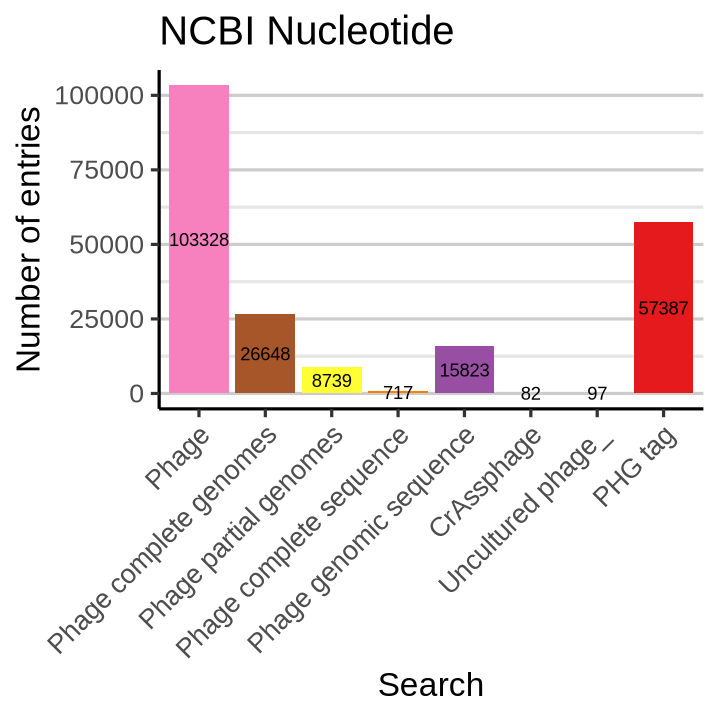

In [8]:
options(repr.plot.width=6, repr.plot.height=6)

## Plot
queries$name <- factor(queries$name, unique(queries$name))
ggplot(queries, aes(name, count, fill=name, label=count)) +
  geom_col() +
  geom_text(position = position_stack(vjust=0.5)) +
  scale_fill_brewer(palette = 'Set1', direction = -1) +
  theme_classic(20) +
  theme(
      panel.grid.major.y = element_line(color = 'grey80'),
      panel.grid.minor.y = element_line(color = 'grey90'),
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(title='NCBI Nucleotide', x = 'Search', y = 'Number of entries')

In [9]:
# Select queries

## Select
selection <- as.character(queries$name[!queries$name %in% c('Phage')])

## Retrieve ENTREZ IDs
data <- list()
for (i in selection) {
    ind <- which(queries$name == i)
    data[[i]] <- data.frame(
        search = i,
        ids = entrez_search(db = queries$db[[ind]], term = queries$term[[ind]], retmax=queries$count[[ind]])$ids        
    )
}
data <- bind_rows(data)
data <- data %>% group_by(ids) %>% summarize(search=paste(unique(search), collapse=','))

## View
dim(data)
rbind(head(data,3), tail(data,3))

## Only unique rows
all(!duplicated(data$ids))

[1] 67749     2

ids,search
<chr>,<chr>
1001940386,"Phage complete genomes,PHG tag"
1001940629,PHG tag
1001940634,"Phage complete genomes,PHG tag"
998289677,PHG tag
998289684,PHG tag
998929,PHG tag


[1] TRUE

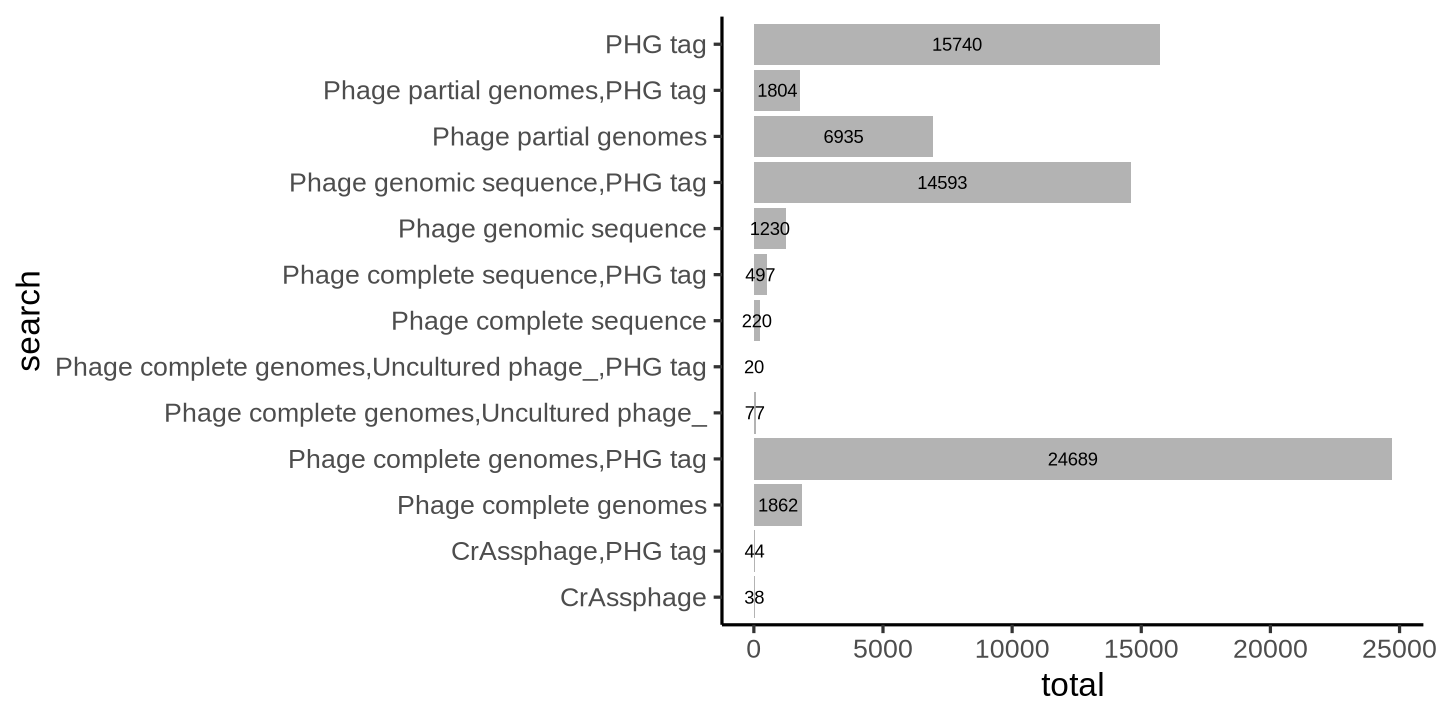

In [10]:
# Visualize overlap
options(repr.plot.width=12, repr.plot.height=6)

## Summarize
df <- data %>% mutate(N=1) %>% group_by(search) %>% summarize(total = sum(N))

## Plot
ggplot(df, aes(total, search, label=total)) +
  geom_col(fill='grey70') +
  geom_text(position = position_stack(vjust = 0.5)) +
  theme_classic(20)

In [11]:
# Fetch Accession.version
n_groups <- ceiling(nrow(data) / 200)
data$batch <- factor(sample(1:n_groups, nrow(data), replace=TRUE))
data$accession.version <- NA
for (i in levels(data$batch)) {
    ind <- which(data$batch == i)
    x <- entrez_fetch(data$ids[ind], db = 'nuccore', rettype = 'acc') %>% str_split(pattern='\\n')
    x <- head(x[[1]], -1)
    data$accession.version[ind] <- x
}

In [12]:
# Modify data

## Extract accession
data$accession <- str_split(data$accession.version, '\\.', simplify=TRUE)[,1]

## Check INPHARED db
data$inphared <- data$accession %in% inphared$Accession
table(inphared$Accession %in% data$accession)

## View
dim(data)
rbind(head(data,3), tail(data,3))

## Checks
any(is.na(data$accession.version))
any(duplicated(data$accession.version))

table(data$accession %in% inphared$Accession)
table(inphared$Accession %in% data$accession)


FALSE  TRUE 
   50 31993 

[1] 67749     6

ids,search,batch,accession.version,accession,inphared
<chr>,<chr>,<fct>,<chr>,<chr>,<lgl>
1001940386,"Phage complete genomes,PHG tag",336,KU522583.1,KU522583,TRUE
1001940629,PHG tag,60,KU159289.1,KU159289,FALSE
1001940634,"Phage complete genomes,PHG tag",197,KU574722.1,KU574722,TRUE
998289677,PHG tag,225,KU646487.1,KU646487,FALSE
998289684,PHG tag,109,KU646488.1,KU646488,FALSE
998929,PHG tag,155,S77324.1,S77324,FALSE


[1] FALSE

[1] FALSE


FALSE  TRUE 
35756 31993 


FALSE  TRUE 
   50 31993 

In [13]:
# Checking missing ids
inphared$Accession[!inphared$Accession %in% data$accession]
mismatched_ids <- c(
    'BK010471'='BK010471.1',
    'KT997847'='Uncultured phage_... genomic sequence',
    'AP0...'='Uncultured phage_... complete genome','LR7...'='uncultured phage genome assembly','HQ633062'='unordered pieces',
    'PP357458'='PQ360875.1','BHU24159'='U24159.1','SPVDNA'='M17988.1','PFDCG'='J02451.1','PX1CG'='J02482.1','C2PVCG'='L48605.1','LAMCG'='J02459.1','B1U32222'='U32222.1','B4PORFSX'='L35061.1','PF3COMN'='M11912.1','BL2CG'='L13696.1',
    'PMULEFTEN'='M64097.1','SFU82619'='Single protein','B2U02303'='U02303.1','CMU41758'='Single protein','MPU46938'='Single protein','PF3COMNY'='M19377.1','F1CCG'='J02448.1','S13CG'='M14428.1','PZACG'='M11813.1','L67CG'='L33769.1',
    'SVU28974'='Single protein','BCP1'='Single protein','BL5GENM'='L06183.1'
)
sum(mismatched_ids %in% data$accession.version)
message('Whatever is missing from the INPHARED database is not worth collecting...')

[1] "BK010471"  "AC171169"  "LR797314"  "KT997847"  "AP013549"  "AP013548" 
 [7] "AP013547"  "AP013546"  "AP013545"  "AP013544"  "AP013543"  "AP013542" 
[13] "AP013541"  "AP013540"  "AP013539"  "AP013538"  "LR756511"  "LR756508" 
[19] "LR756504"  "LR756503"  "LR756502"  "LR756501"  "LR756500"  "LR745208" 
[25] "LR745206"  "HQ633062"  "PP357458"  "BHU24159"  "SPVDNA"    "PFDCG"    
[31] "PX1CG"     "C2PVCG"    "LAMCG"     "B1U32222"  "B4PORFSX"  "PF3COMN"  
[37] "BL2CG"     "PMULEFTEN" "SFU82619"  "B2U02303"  "CMU41758"  "MPU46938" 
[43] "PF3COMNY"  "F1CCG"     "S13CG"     "PZACG"     "L67CG"     "SVU28974" 
[49] "BCP1"      "BL5GENM"

[1] 19

Whatever is missing from the INPHARED database is not worth collecting...



`summarise()` has grouped output by 'search'. You can override using the
`.groups` argument.


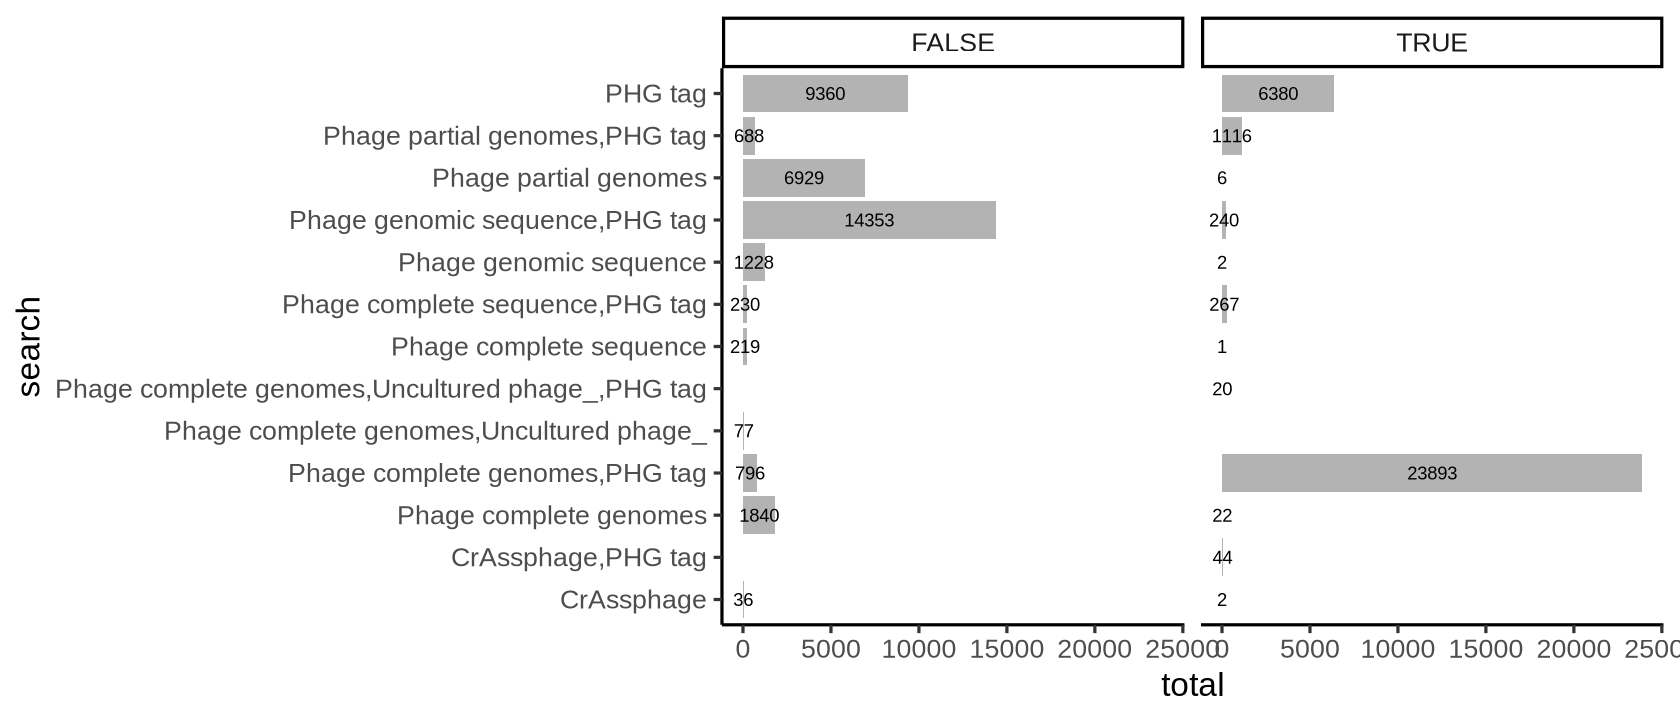

In [14]:
# Visualize overlap
options(repr.plot.width=14, repr.plot.height=6)

## Summarize
df <- data %>% mutate(N=1) %>% group_by(search, inphared) %>% summarize(total = sum(N))

## Plot
ggplot(df, aes(total, search, label=total)) +
  geom_col(fill='grey70') +
  geom_text(position = position_stack(vjust = 0.5)) +
  facet_wrap(~inphared) +
  theme_classic(20)

In [15]:
# Check IDs

## Unique
length(unique(data$ids))
length(unique(data$accession.version))

## Overlap of query and selection
table(tables$phages$accession %in% data$accession.version)

## Data split
table(data$inphared)

[1] 67749

[1] 67749


TRUE 
  35 


FALSE  TRUE 
35756 31993 

In [361]:
# Filter to INPHARED DB
# Since the download is a bit unstable, filter will be applied later...
#data <- data[which(data$inphared), ]

In [20]:
# Split data into types

## Test/Training data
data$type <- 'test'
data$type[data$accession.version %in% tables$phages$accession] <- 'training'

## Validation
#index <- which(data$type == 'test' & data$accession.version %in% sel$genome_accession)
#data$type[index] <- 'validation'

## View
rbind(head(data,3), tail(data,3))

## Check data split
table(data$type)

ids,search,batch,accession.version,accession,inphared,type
<chr>,<chr>,<fct>,<chr>,<chr>,<lgl>,<chr>
1001940386,"Phage complete genomes,PHG tag",336,KU522583.1,KU522583,TRUE,test
1001940629,PHG tag,60,KU159289.1,KU159289,FALSE,test
1001940634,"Phage complete genomes,PHG tag",197,KU574722.1,KU574722,TRUE,test
998289677,PHG tag,225,KU646487.1,KU646487,FALSE,test
998289684,PHG tag,109,KU646488.1,KU646488,FALSE,test
998929,PHG tag,155,S77324.1,S77324,FALSE,test



    test training 
   67714       35 

In [25]:
# Export accession numbers
write.table(data, fn$overview, sep = ',', quote = FALSE, row.names = FALSE)

## Training data
index <- which(data$type == 'training')
writeLines(data$accession.version[index], fn$training)

## Validation data
#index <- which(data$type == 'validation')
#writeLines(data$accession.version[index], fn$validation)

## Test data
index <- which(data$type == 'test')
writeLines(data$accession.version[index], fn$test)

In [26]:
# Download training data
download_ncbi_genomes(inputfile = fn$training)

datasets download virus genome accession --inputfile data/training/accession.txt --filename data/training/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/training/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/training/ncbi_dataset/data/annotation_report.jsonl > data/training/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/training/ncbi_dataset/data/data_report.jsonl > data/training/ncbi_dataset/data/metadata.tsv 



All accession IDs retrieved successfully



Done.

In [27]:
# Download validation data
#download_ncbi_genomes(inputfile = fn$validation, overwrite = TRUE)

In [28]:
# Download test data
download_ncbi_genomes(inputfile = fn$test)

datasets download virus genome accession --inputfile data/test/accession.txt --filename data/test/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/test/ncbi_dataset/data/annotation_report.jsonl > data/test/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/test/ncbi_dataset/data/data_report.jsonl > data/test/ncbi_dataset/data/metadata.tsv 



Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in download_ncbi_genomes(inputfile = fn$test):
“Not all accession IDs retrieved. Exporting missing IDs...”


Entries retrieved: 22718 of 67714 

Done.

In [30]:
# Find missing entries
acc <- readLines('data/test/missing_accessions.txt')
length(acc)

[1] 44996

In [31]:
dir.create('data/test2/', recursive = TRUE)
file.copy('data/test/missing_accessions.txt','data/test2/accession.txt')

[1] TRUE

In [32]:
## Download missing genomes (into different archive, iterate)
download_ncbi_genomes('data/test2/accession.txt')

datasets download virus genome accession --inputfile data/test2/accession.txt --filename data/test2/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test2/download.log 2>&1 

Unzip



Checksums identical. Files were downloaded without problems.



dataformat tsv virus-annotation --inputfile data/test2/ncbi_dataset/data/annotation_report.jsonl > data/test2/ncbi_dataset/data/features.gtf 

dataformat tsv virus-genome --inputfile data/test2/ncbi_dataset/data/data_report.jsonl > data/test2/ncbi_dataset/data/metadata.tsv 



Warning message in download_ncbi_genomes("data/test2/accession.txt"):
“Not all accession IDs retrieved. Exporting missing IDs...”


Entries retrieved: 43177 of 44996 

Done.

In [34]:
# Find missing entries
acc <- readLines('data/test2/missing_accessions.txt')
length(acc)

[1] 1819

In [35]:
dir.create('data/test3/', recursive = TRUE)
file.copy('data/test2/missing_accessions.txt','data/test3/accession.txt')

[1] TRUE

In [36]:
## Download missing genomes (into different archive, iterate)
download_ncbi_genomes('data/test3/accession.txt')

datasets download virus genome accession --inputfile data/test3/accession.txt --filename data/test3/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test3/download.log 2>&1 



Warning message in system(call_datasets, intern = TRUE):
“running command 'datasets download virus genome accession --inputfile data/test3/accession.txt --filename data/test3/ncbi_dataset.zip --include genome,cds,protein,annotation,biosample > data/test3/download.log 2>&1' had status 1”


Unzip



Warning message in unzip(zipfile, exdir = PATH):
“error 1 in extracting from zip file”
Warning message in file(file, "rt"):
“cannot open file 'data/test3/md5sum.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [37]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1 tidyr_1.3.1   dplyr_1.1.4   rentrez_1.2.3 stringr_1.5.1
[6] readxl_1.4.3 

loaded via a namespace (and not attached):
 [1] bit_4.5.0.1        gtable_0.3.6       jsonlite_1.8.9     compiler_4.4.2    
 [5] crayon_1.5.3       tidyselect_1.2.1   IRdisplay_1.1 